# Test Result Evaluation

This notebook is used to evaluate the results of the tests performed in the `tests.ipynb` notebook.
If you ran the tests yourself, you can use this notebook to visualize the results. Otherwise, you can use the results, which were already generated and delivered with the project.

The csv files containing the results of the tests are loaded and prepared for plotting. The plotting is done using the `matplotlib` library.

In [6]:
import os

local_path = os.path.join(os.getcwd(), 'data')
result_folder_path = os.path.join(os.getcwd(), 'test_results_delivered')

# Uncomment the following line if you ran the tests yourself and want to visualize the results
# result_folder_path = os.path.join(os.getcwd(), 'test_results_new')

## Data Size

The total size of the csv files, which were downloaded initially, is calculated and compared with the total size after they were compressed into parquet files.

In [7]:
import math
import pandas as pd

df_data_size = pd.read_csv(os.path.join(result_folder_path, 'data_size.csv'), sep=';', index_col=0)

total_data_size_csv = df_data_size['input_data'].sum()
total_data_size_parquet = df_data_size['output_data'].sum()

print(f"Total size of csv files: {total_data_size_csv} Bytes, {round(total_data_size_csv/ math.pow(10, 9), 2)} GB")
print(f"Total size of parquet files: {total_data_size_parquet} Bytes, {round(total_data_size_parquet/ math.pow(10, 9), 2)} GB")
print(f"Compression factor: {round(total_data_size_csv/total_data_size_parquet, 2)}")
print(f"Space reduction: {round((1 - total_data_size_parquet/total_data_size_csv) * 100, 2)}%")

Total size of csv files: 185907385530 Bytes, 185.91 GB
Total size of parquet files: 32904171770 Bytes, 32.9 GB
Compression factor: 5.65
Space reduction: 82.3%


## Definition of Helper Methods

Calculation of total data size used for a test run according to the parquet files, which were included in the test run.

In [8]:
# Method to calculate the size of the data used for the respective test run
def calculate_data_size(row, df_data_size):
    # Index of the last file used for this test
    last_file_index = row['last_file_index']

    # Filter for all files which were used to perform this test
    relevant_data = df_data_size[df_data_size.index <= last_file_index]

    # Calculate the size of the data used for this test run
    parquet_size = round(relevant_data['output_data'].sum()/ math.pow(10, 9), 2)

    return parquet_size

Preparation of the result data for plotting by replacing zero values with NaN for failed tests and appending the size of the data used for the respective test run.

In [9]:
import numpy as np

def prepare_result_data(df):
    # Calculate the size of the data used for the respective test run
    df['parquet_size'] = df.apply(lambda row: calculate_data_size(row, df_data_size), axis=1, result_type='expand')

    # Replace 0 values with NaN for failed tests, to plot them correctly
    df.loc[df['status'] == 'FAILED', :] = df.loc[df['status'] == 'FAILED', :].replace(0, np.nan)

    return df

Plotting of line graphs

In [10]:
import matplotlib.pyplot as plt
import matplotlib.style as style

# Plot line graph
def plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b=None, aggregated=True):

    style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 6), dpi=300)

    if df_b is not None:
        plt.plot(df_a[x_column_name], df_a[y_column_name], marker='o', color='steelblue', label='Aggregated')
        plt.plot(df_b[x_column_name], df_b[y_column_name], marker='o', color='darkorange', label='Non-aggregated')

    else:
        if aggregated:
            plt.plot(df_a[x_column_name], df_a[y_column_name], marker='o', color='steelblue', label='Aggregated')
        else:
            plt.plot(df_a[x_column_name], df_a[y_column_name], marker='o', color='darkorange', label='Non-aggregated')

        plt.scatter(df_a[x_column_name][df_a[y_column_name].isna()], [0] * df_a[y_column_name].isna().sum(), color='red', marker='x', label='Failed test run')

    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(frameon=True)
    plt.grid(True)

Plotting of bar graphs

In [11]:
import matplotlib.pyplot as plt
import matplotlib.style as style

# Add data labels to the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Plot bar graph
def plot_bar_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b):

    style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 6), dpi=300)

    width = 0.35
    x_positions = range(len(df_a))

    bars_a = plt.bar(x_positions, df_a[y_column_name], width, color='steelblue', label='Aggregated')
    bars_b = plt.bar([p + width for p in x_positions], df_b[y_column_name], width, color='darkorange', label='Non-aggregated')

    plt.xticks([p + width / 2 for p in x_positions], df_a[x_column_name])

    add_labels(bars_a)
    add_labels(bars_b)

    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(frameon=True)

    plt.show()

## Test Results of Data Volume Scalability Tests

In [12]:
# Result data of data volume scalability tests (aggregated)
df_result_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_data_volume_aggregated.csv'), sep=';', index_col=0)
df_result_aggregated = prepare_result_data(df_result_aggregated)

# Result data of data volume scalability tests (non-aggregated)
df_result_non_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_data_volume_non_aggregated.csv'), sep=';', index_col=0)
df_result_non_aggregated = prepare_result_data(df_result_non_aggregated)

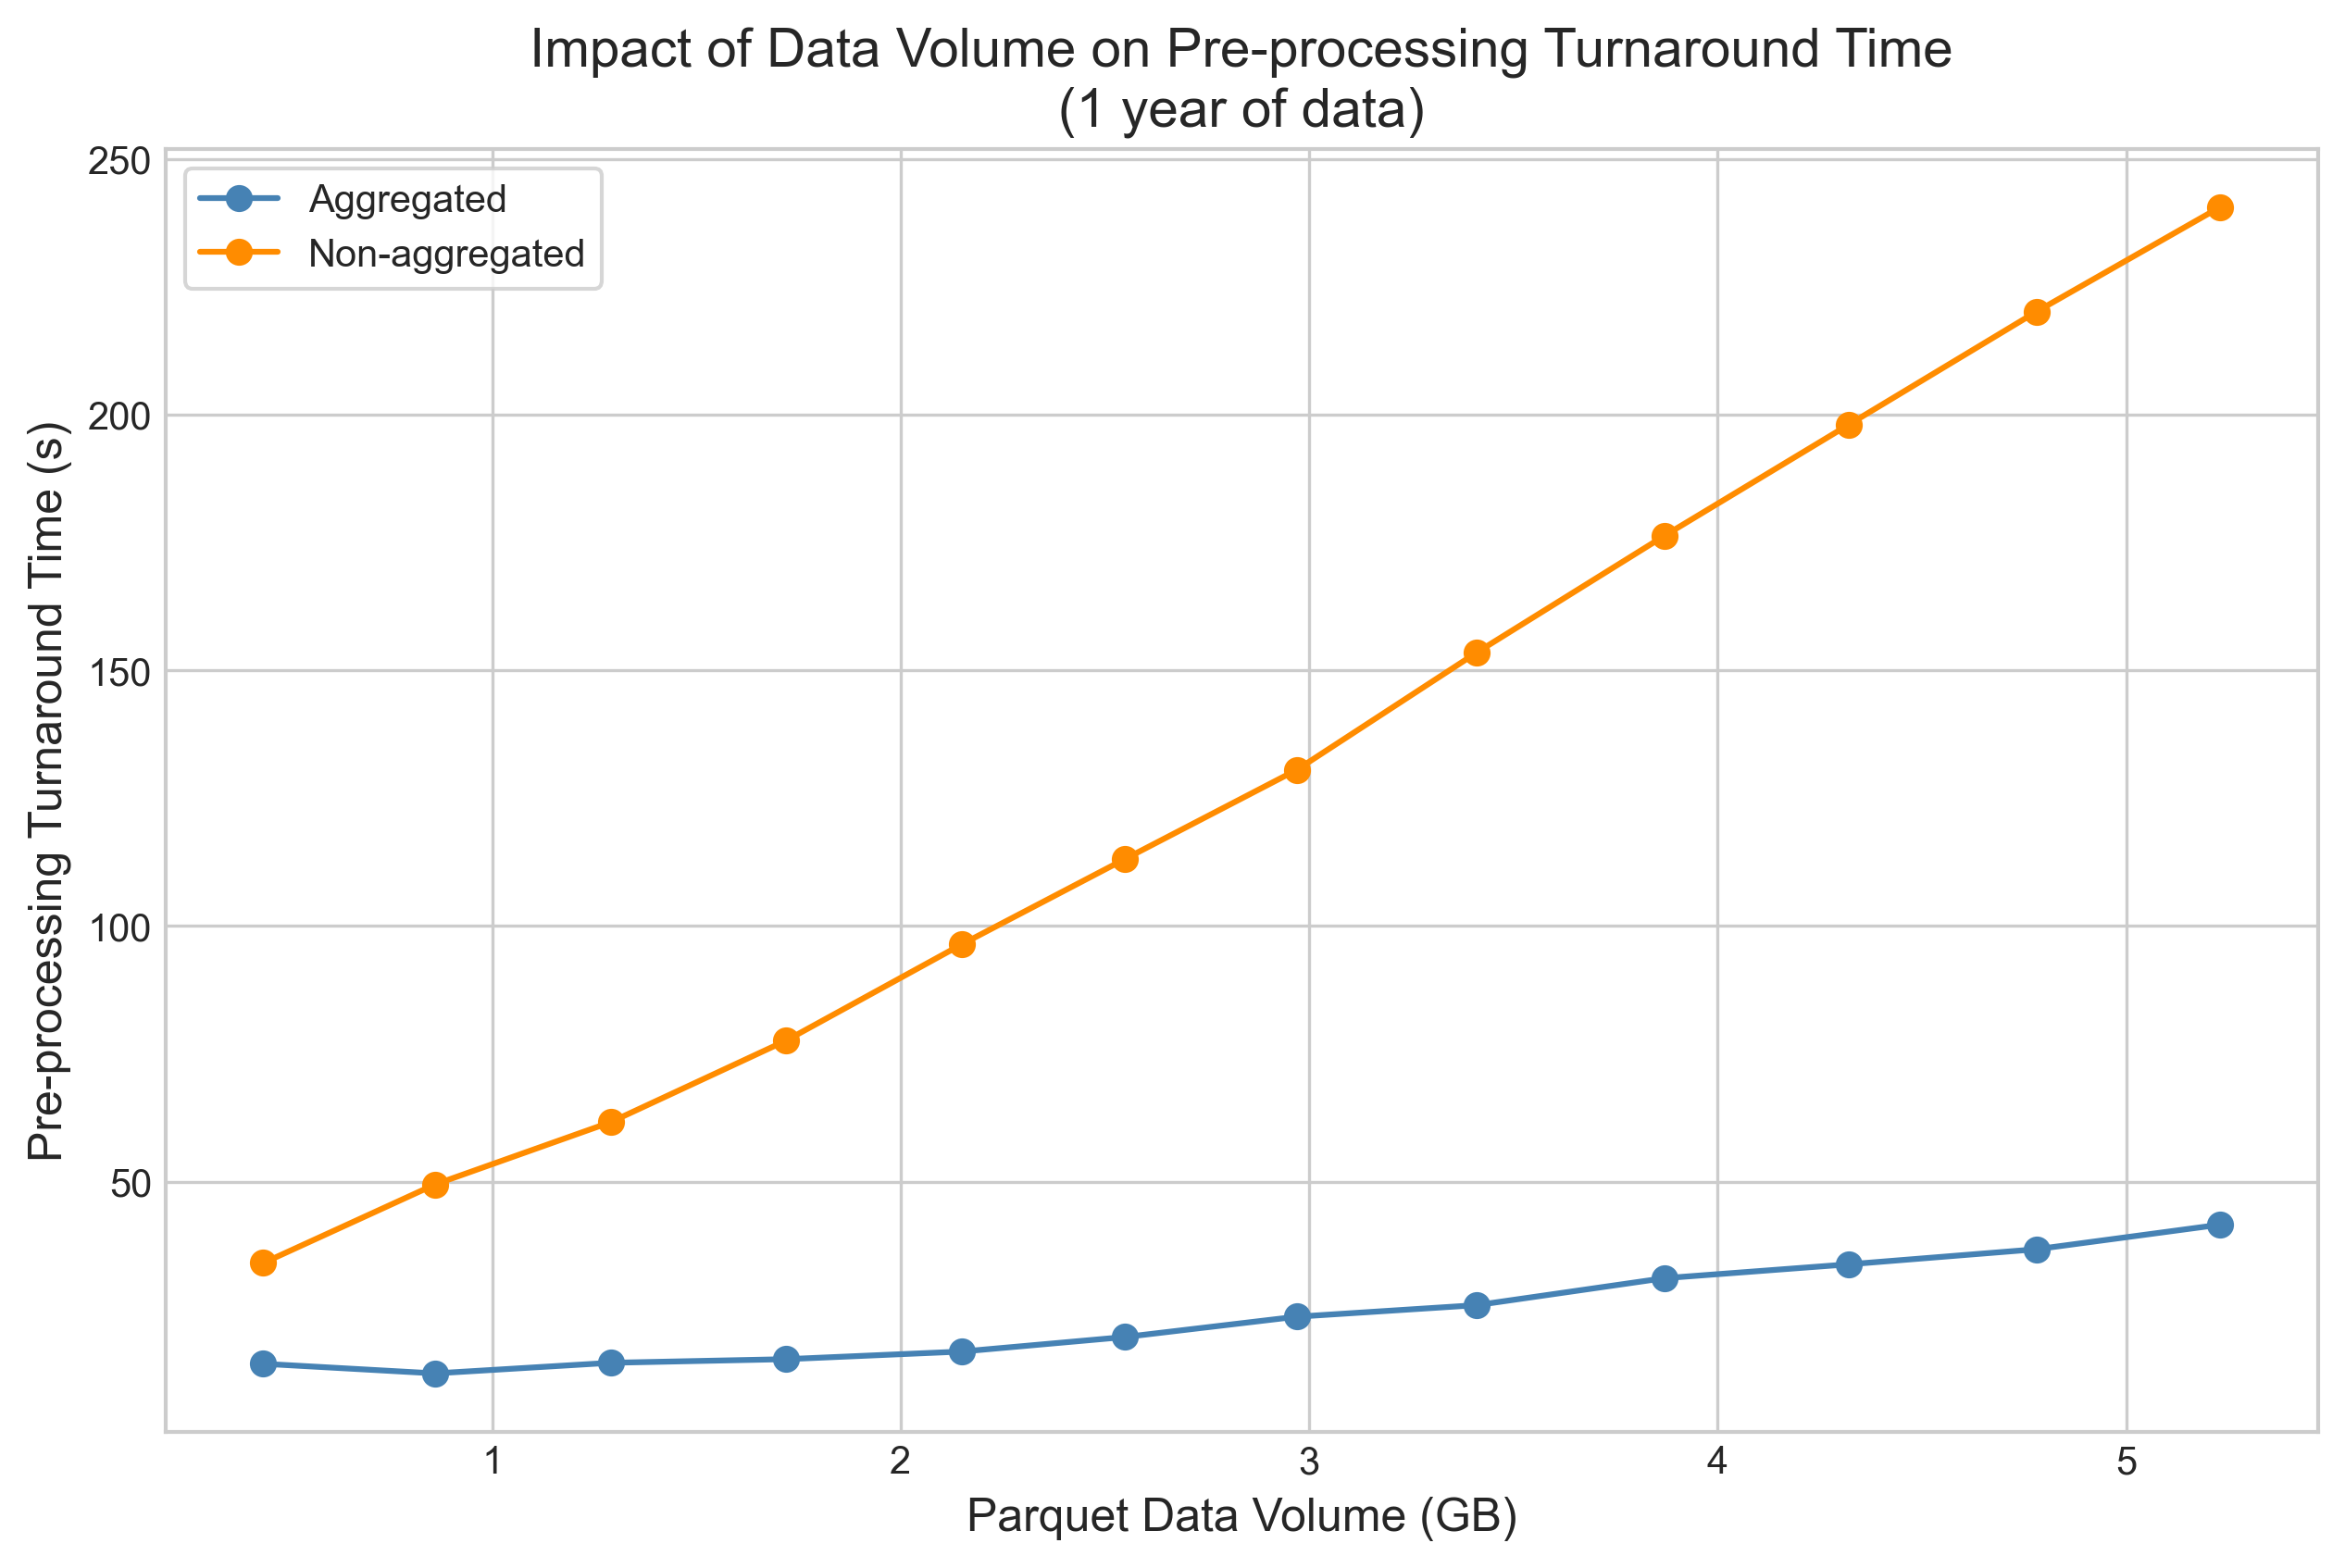

In [13]:
# Filter for 1 year of data
df_a = df_result_aggregated.where(df_result_aggregated['last_file_index'] <= 11)
df_b = df_result_non_aggregated.where(df_result_non_aggregated['last_file_index'] <= 11)

x_column_name = 'parquet_size'
y_column_name = 'duration'

title = 'Impact of Data Volume on Pre-processing Turnaround Time\n(1 year of data)'
x_label = 'Parquet Data Volume (GB)'
y_label = 'Pre-processing Turnaround Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)
plt.show()

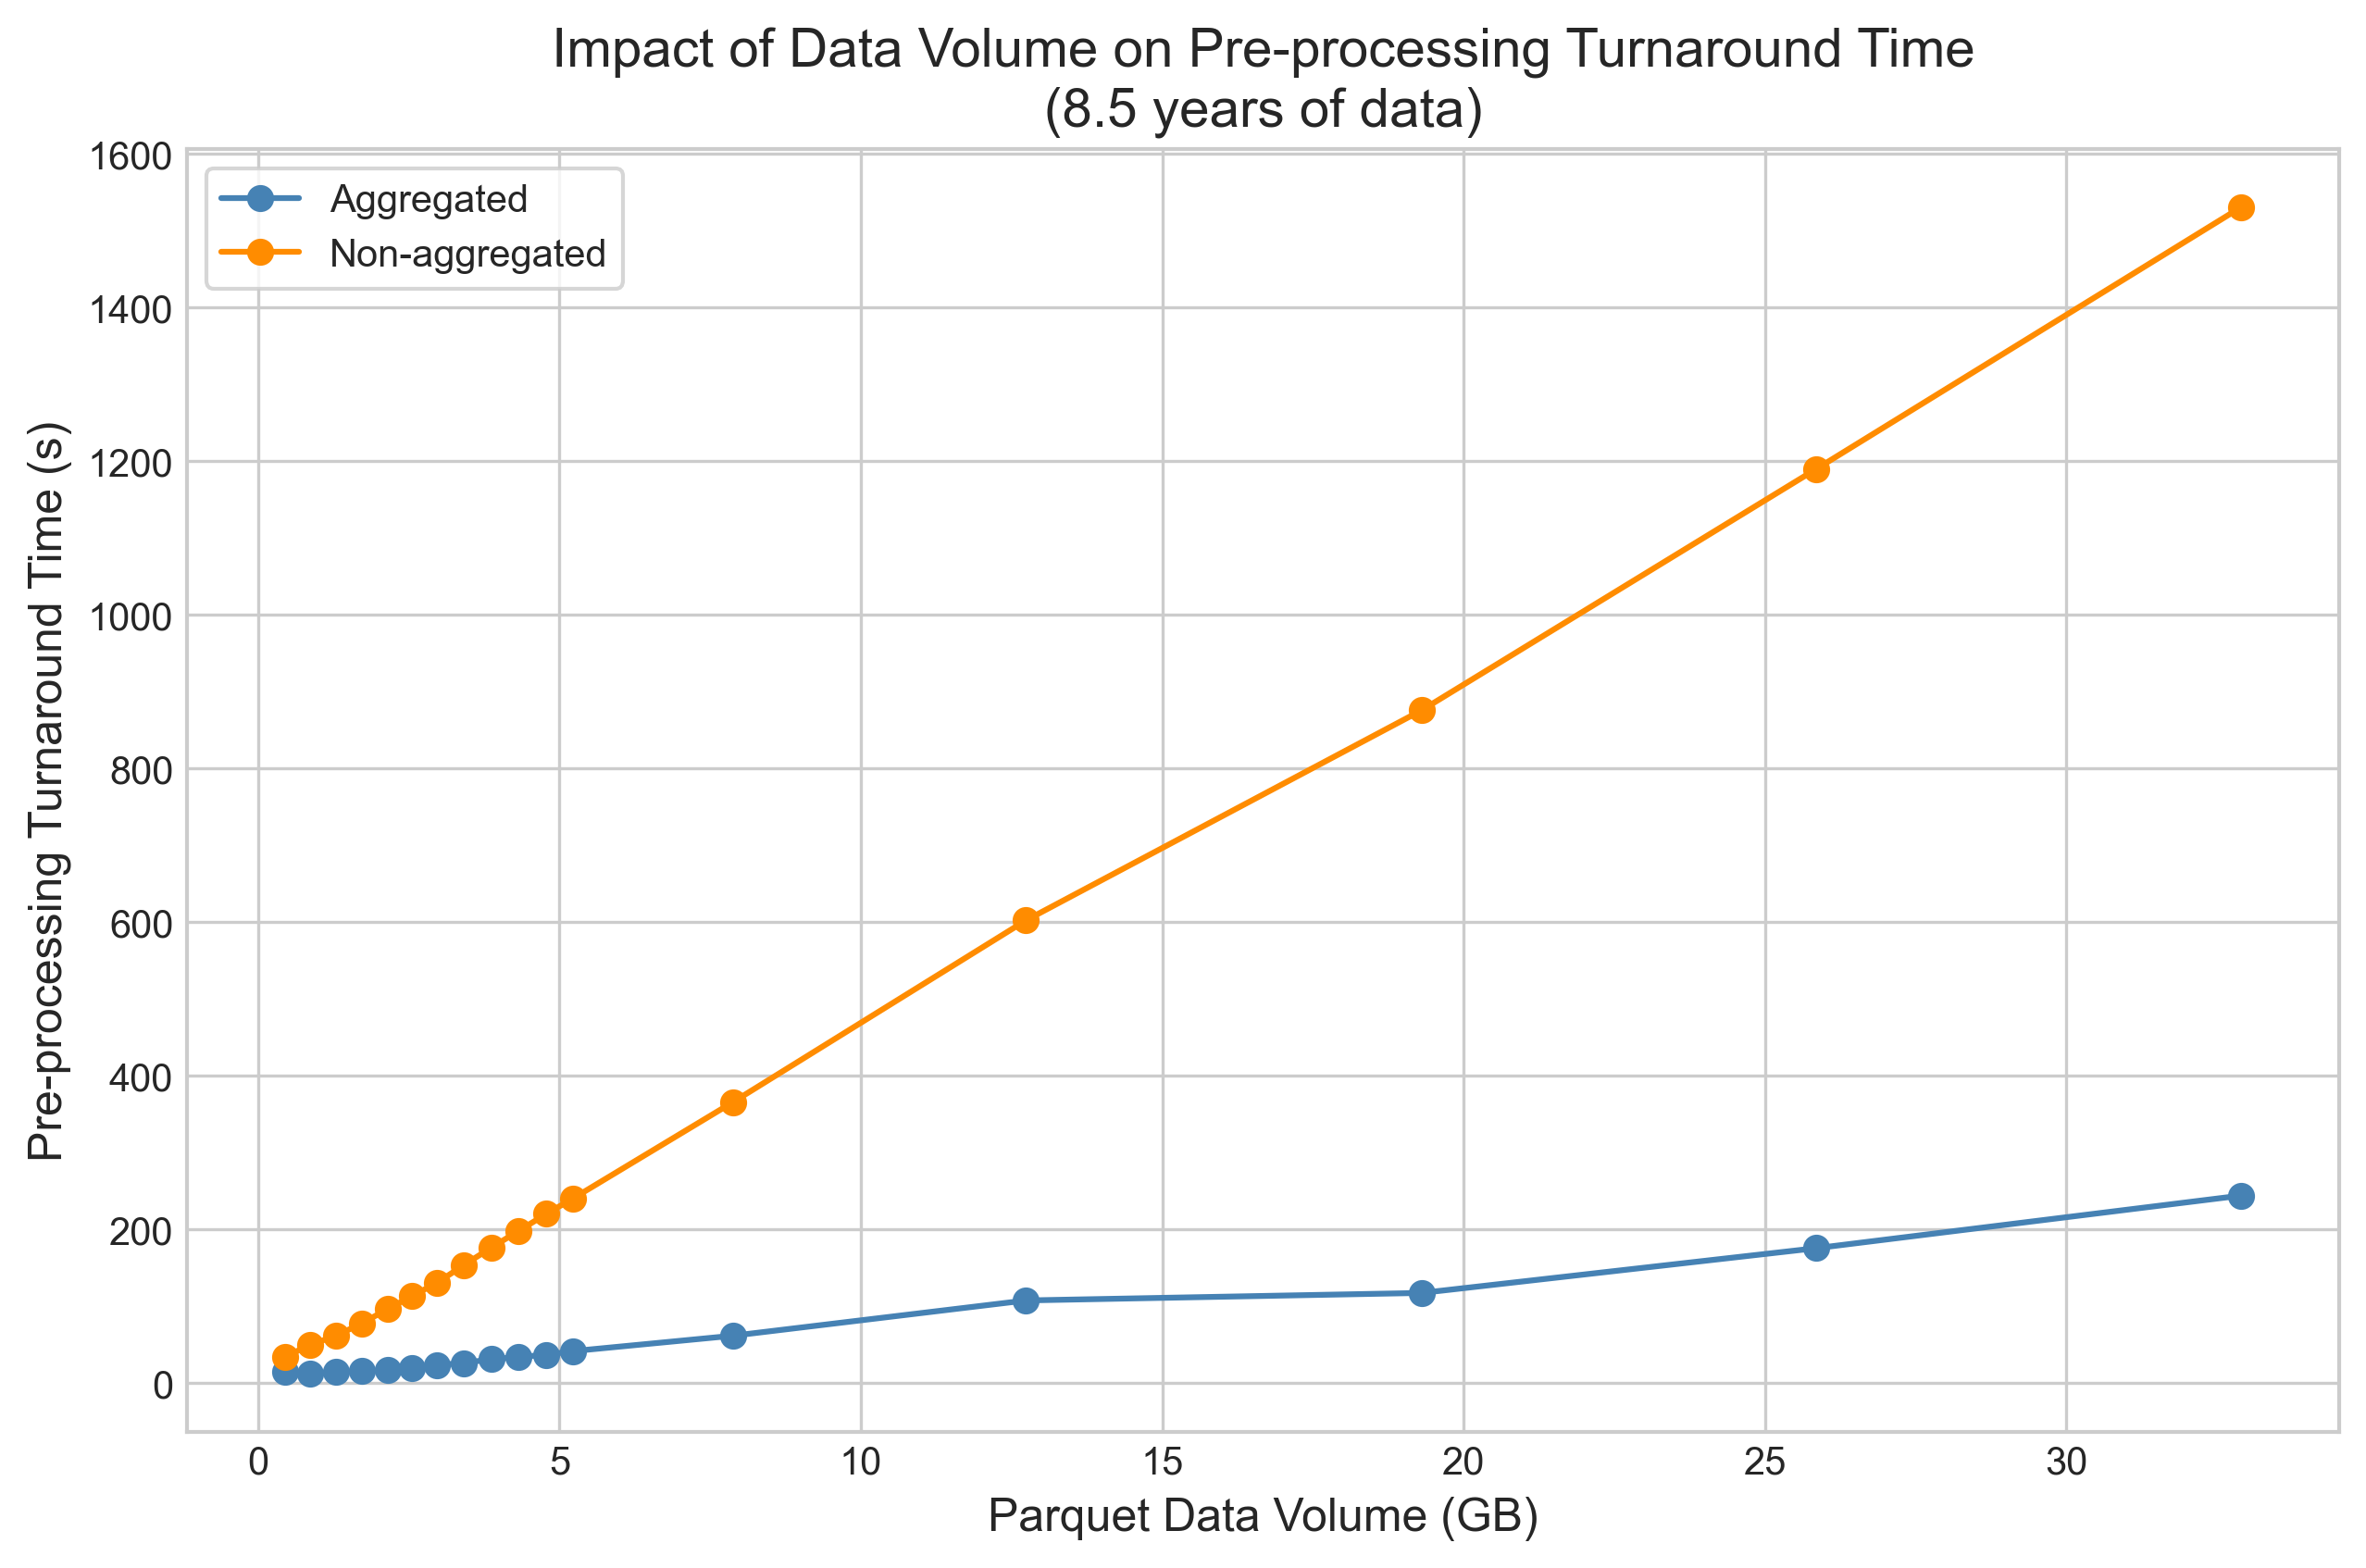

In [14]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'parquet_size'
y_column_name = 'duration'

title = 'Impact of Data Volume on Pre-processing Turnaround Time\n(8.5 years of data)'
x_label = 'Parquet Data Volume (GB)'
y_label = 'Pre-processing Turnaround Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()

Factor by which the pre-processing time increases compared to the data volume on average

In [15]:
delta_duration_aggregated = df_result_aggregated['duration'].iloc[-1] - df_result_aggregated['duration'].iloc[0]
delta_volume_aggregated = df_result_aggregated['parquet_size'].iloc[-1] - df_result_aggregated['parquet_size'].iloc[0]
delta_duration_non_aggregated = df_result_non_aggregated['duration'].iloc[-1] - df_result_non_aggregated['duration'].iloc[0]
delta_volume_non_aggregated = df_result_non_aggregated['parquet_size'].iloc[-1] - df_result_non_aggregated['parquet_size'].iloc[0]

print(f"Average increase of pre-processing time compared to data volume (aggregated): {delta_duration_aggregated/delta_volume_aggregated} s/GB")
print(f"Average increase of pre-processing time compared to data volume (non-aggregated): {delta_duration_non_aggregated/delta_volume_non_aggregated} s/GB")

Average increase of pre-processing time conmpared to data volume (aggregated): 7.073670218039352 s/GB
Average increase of pre-processing time conmpared to data volume (non-aggregated): 46.11025283311666 s/GB


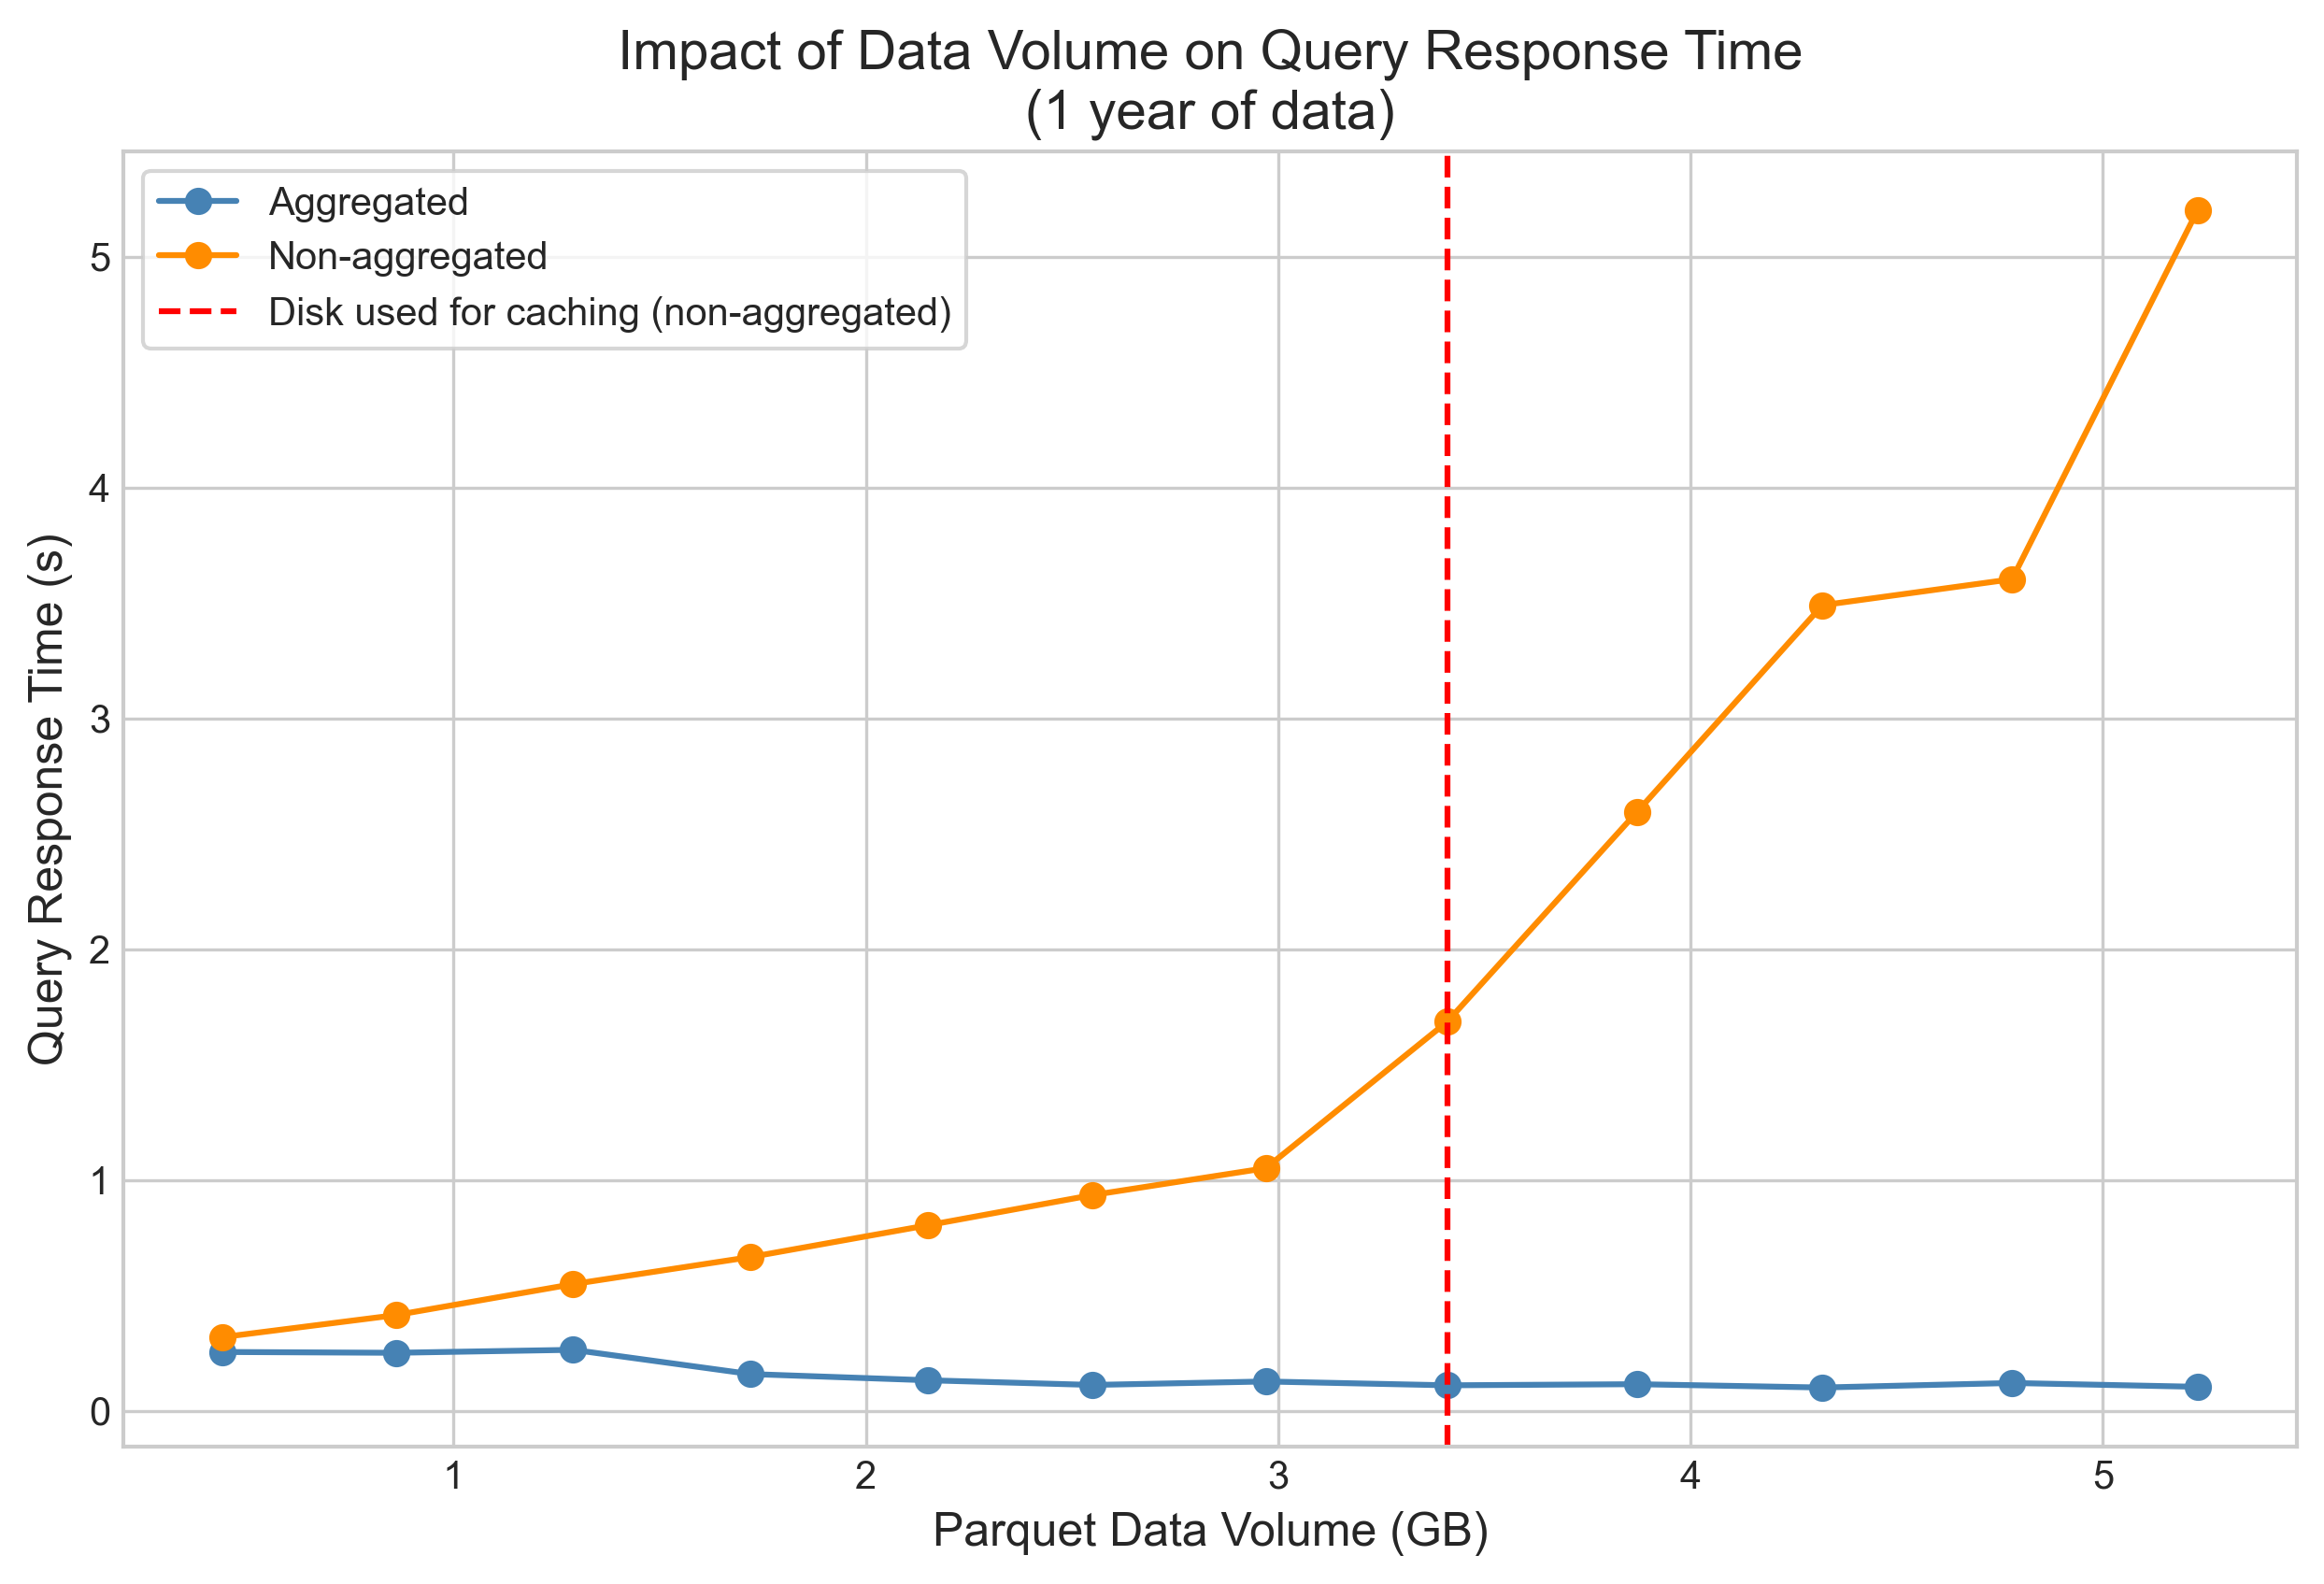

In [16]:
# Filter for 1 year of data
df_a = df_result_aggregated.where(df_result_aggregated['last_file_index'] <= 11)
df_b = df_result_non_aggregated.where(df_result_non_aggregated['last_file_index'] <= 11)

x_column_name = 'parquet_size'
y_column_name = 'avg_req_time'

title = 'Impact of Data Volume on Query Response Time\n(1 year of data)'
x_label = 'Parquet Data Volume (GB)'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

# Add a vertical line where the disk is used for caching for the first time
disk_used_for_cache = df_b[df_b['disk_usage'] > 0][x_column_name].iloc[0]
plt.axvline(x=disk_used_for_cache, color='r', linestyle='--', label='Disk used for caching (non-aggregated)')
plt.legend(frameon=True)

plt.show()

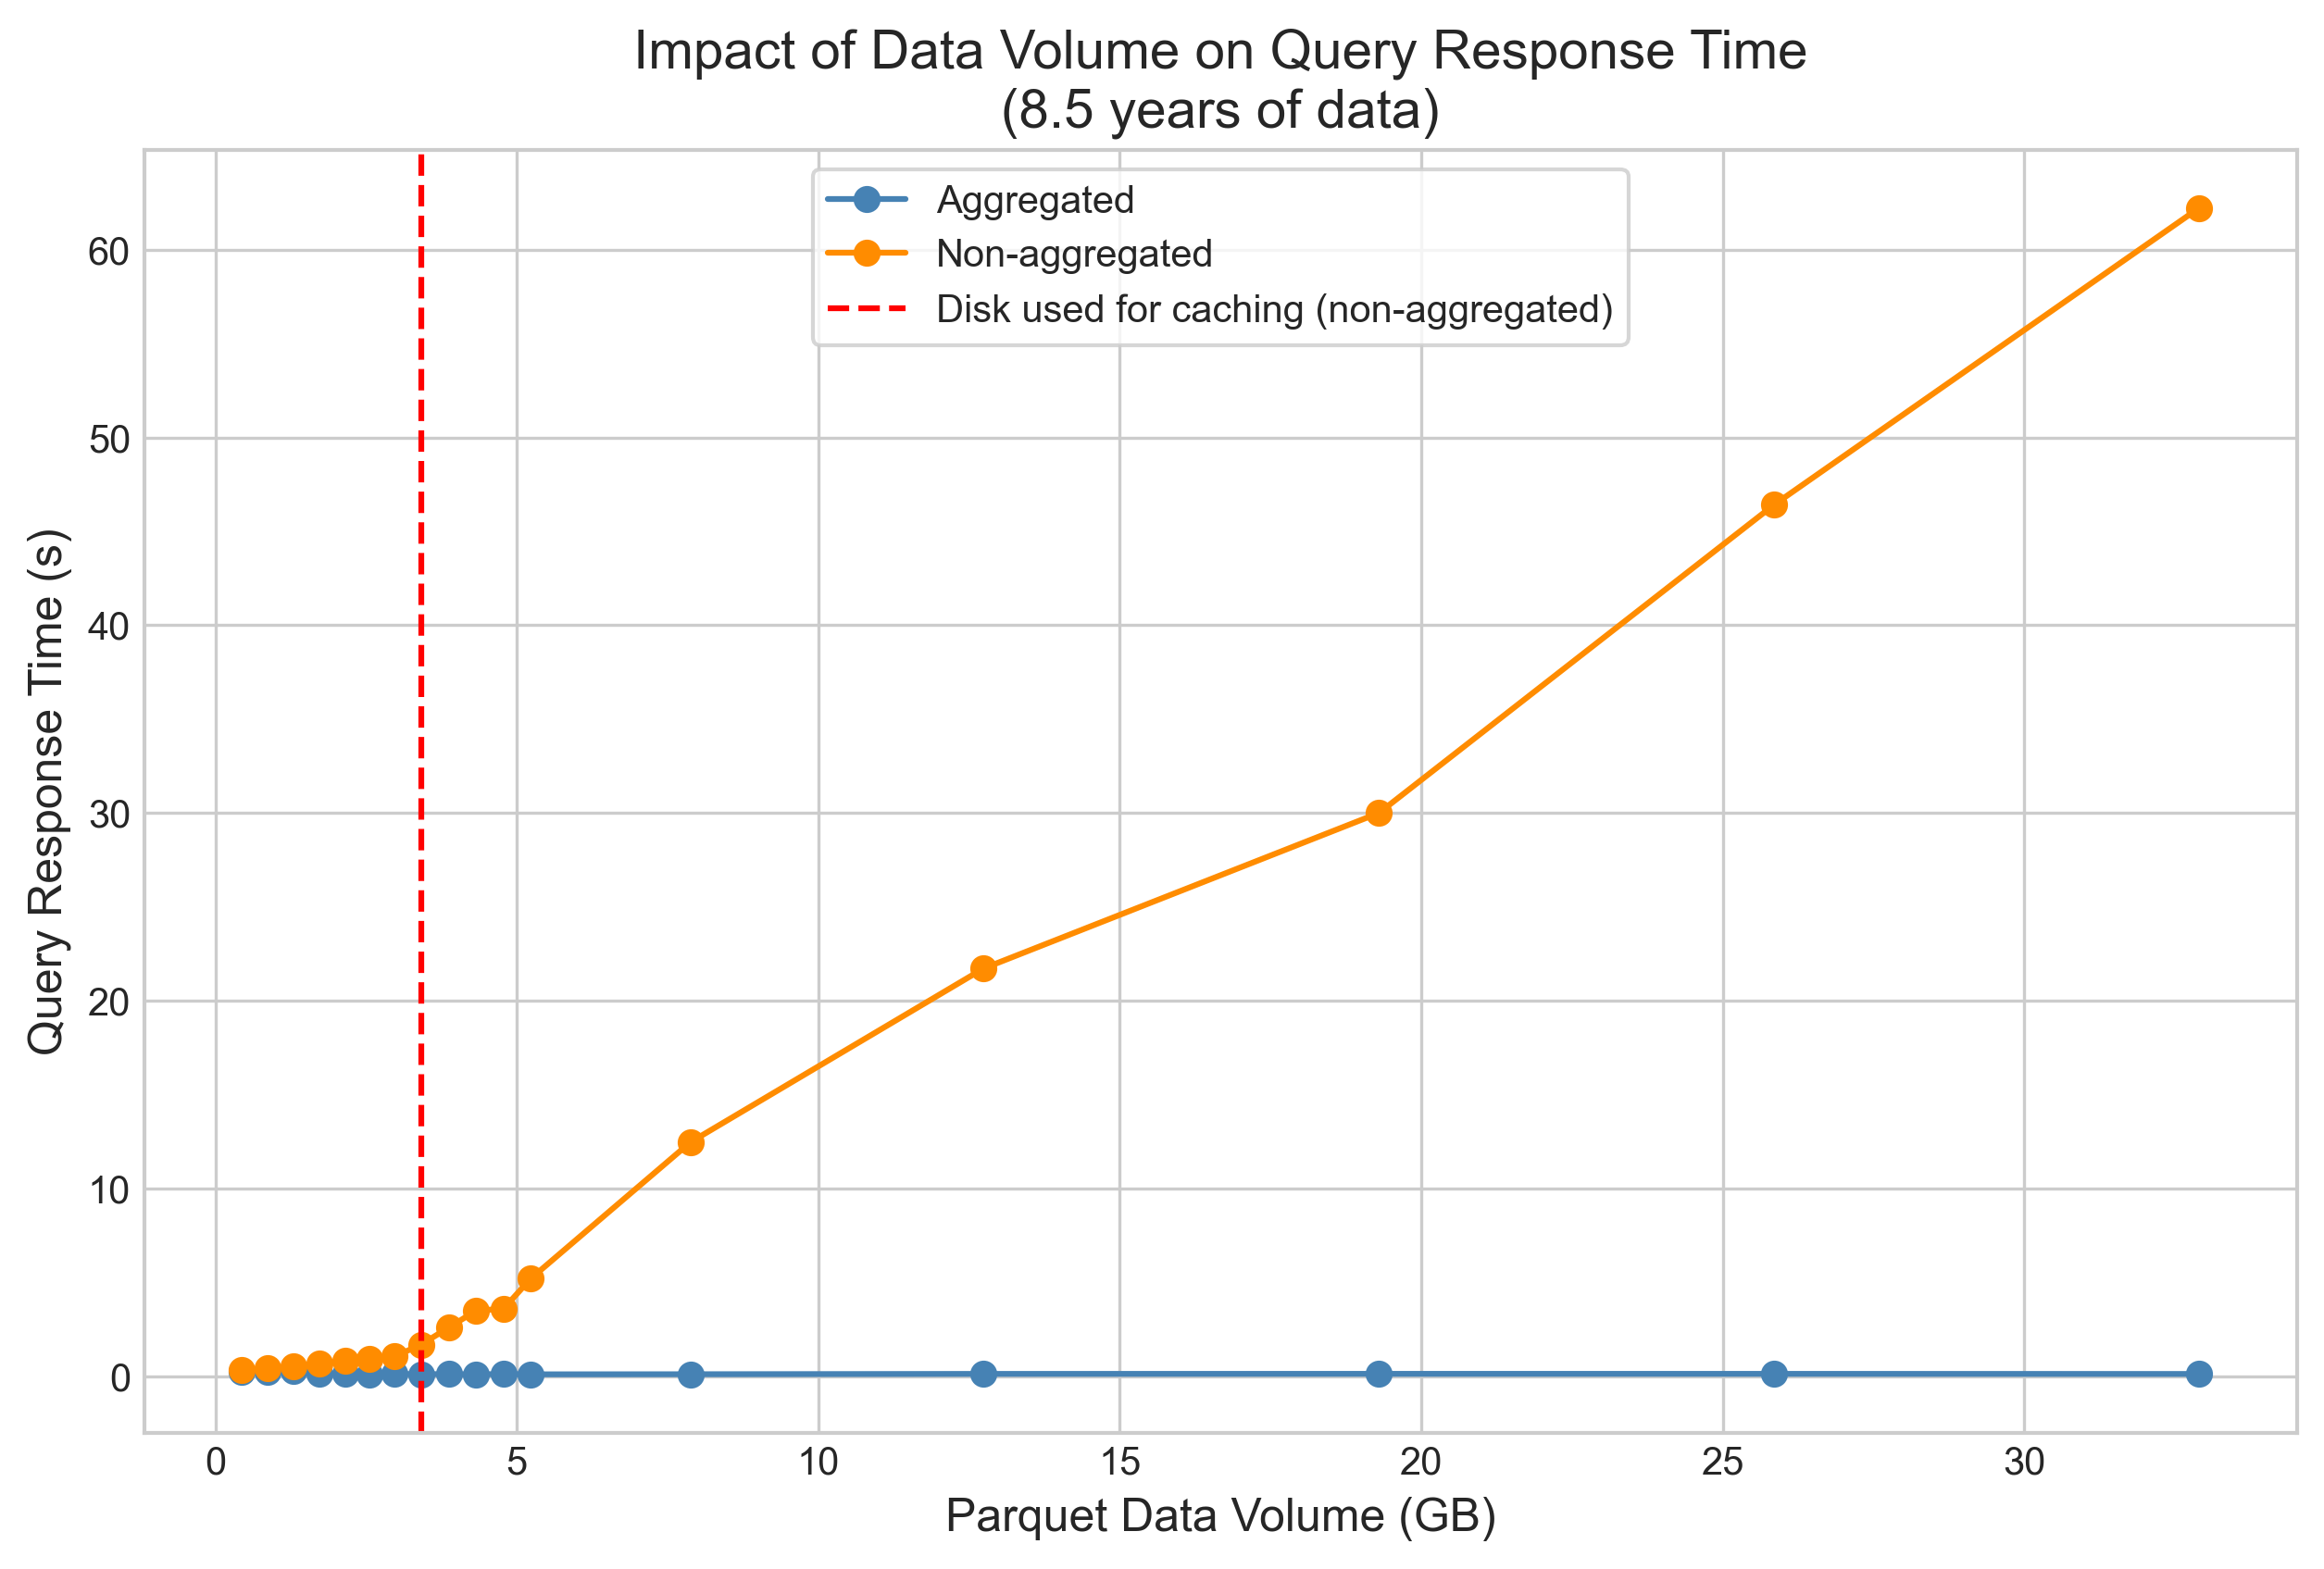

In [17]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'parquet_size'
y_column_name = 'avg_req_time'

title = 'Impact of Data Volume on Query Response Time\n(8.5 years of data)'
x_label = 'Parquet Data Volume (GB)'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

# Add a vertical line where the disk is used for caching for the first time
disk_used_for_cache = df_b[df_b['disk_usage'] > 0][x_column_name].iloc[0]
plt.axvline(x=disk_used_for_cache, color='r', linestyle='--', label='Disk used for caching (non-aggregated)')
plt.legend(frameon=True)

plt.show()

Disk and memory usage of the cache when the complete dataset is included

In [18]:
disk_usage_aggregated = df_result_aggregated['disk_usage'].iloc[-1]
memory_usage_aggregated = df_result_aggregated['memory_usage'].iloc[-1]

disk_usage_non_aggregated = df_result_non_aggregated['disk_usage'].iloc[-1]
memory_usage_non_aggregated = df_result_non_aggregated['memory_usage'].iloc[-1]

print(f"Cache usage (aggregated): {round(disk_usage_aggregated/math.pow(10, 6), 2)} MB disk, {round(memory_usage_aggregated/math.pow(10, 6), 2)} MB memory")
print(f"Cache usage (non-aggregated): {round(disk_usage_non_aggregated/math.pow(10, 6), 2)} MB disk, {round(memory_usage_non_aggregated/math.pow(10, 6), 2)} MB memory")

print(f"Total cache space requirements (aggregated): {round((disk_usage_aggregated + memory_usage_aggregated)/math.pow(10, 6), 2)} MB")
print(f"Total cache space requirements (non-aggregated): {round((disk_usage_non_aggregated + memory_usage_non_aggregated)/math.pow(10, 6), 2)} MB")

Cache usage (aggregated): 0.0 MB disk, 12.41 MB memory
Cache usage (non-aggregated): 65386.72 MB disk, 9475.92 MB memory
Total cache space requirements (aggregated): 12.41 MB
Total cache space requirements (non-aggregated): 74862.65 MB


## Test Results of Load Scalability Tests

In [19]:
# Result data of data volume scalability tests (aggregated)
df_result_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_load_aggregated.csv'), sep=';', index_col=0)
df_result_aggregated = prepare_result_data(df_result_aggregated)

# Result data of data volume scalability tests (non-aggregated)
df_result_non_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_load_non_aggregated.csv'), sep=';', index_col=0)
df_result_non_aggregated = prepare_result_data(df_result_non_aggregated)

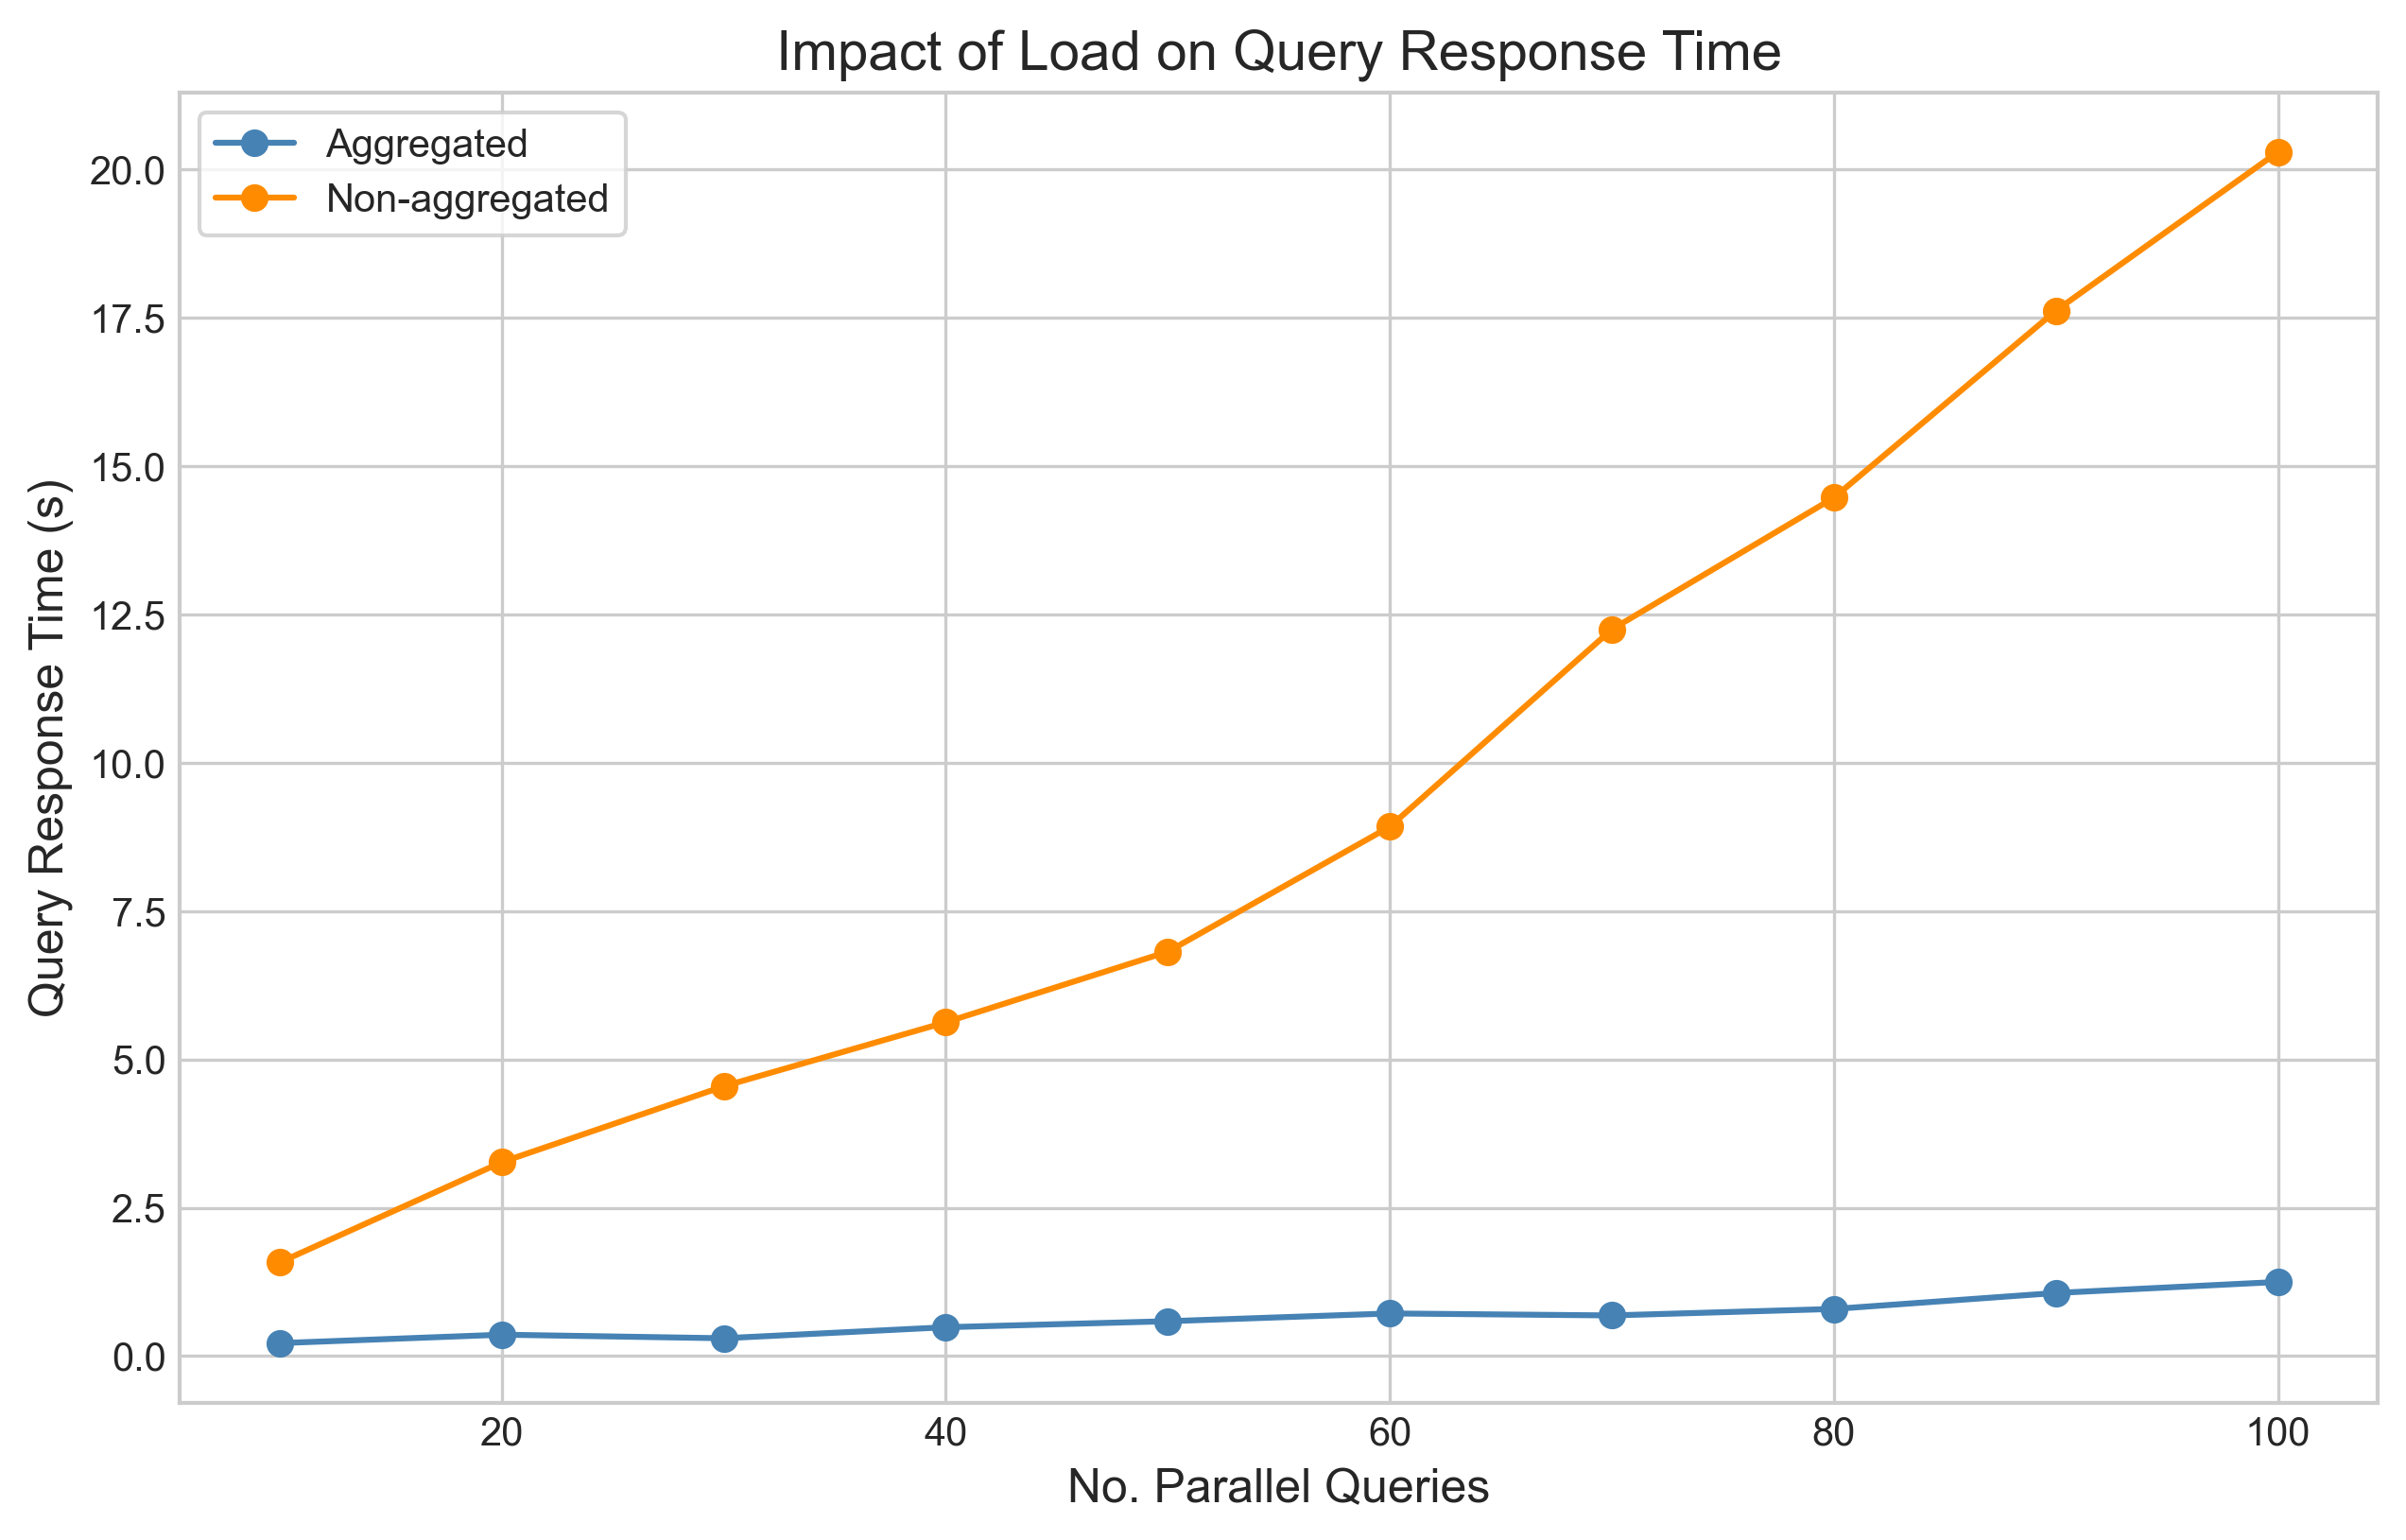

In [20]:
# Filter for 250 parallel queries
df_a = df_result_aggregated.where(df_result_aggregated['parallel_queries'] <= 100)
df_b = df_result_non_aggregated.where(df_result_non_aggregated['parallel_queries'] <= 100)

x_column_name = 'parallel_queries'
y_column_name = 'avg_req_time'

title = 'Impact of Load on Query Response Time'
x_label = 'No. Parallel Queries'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()

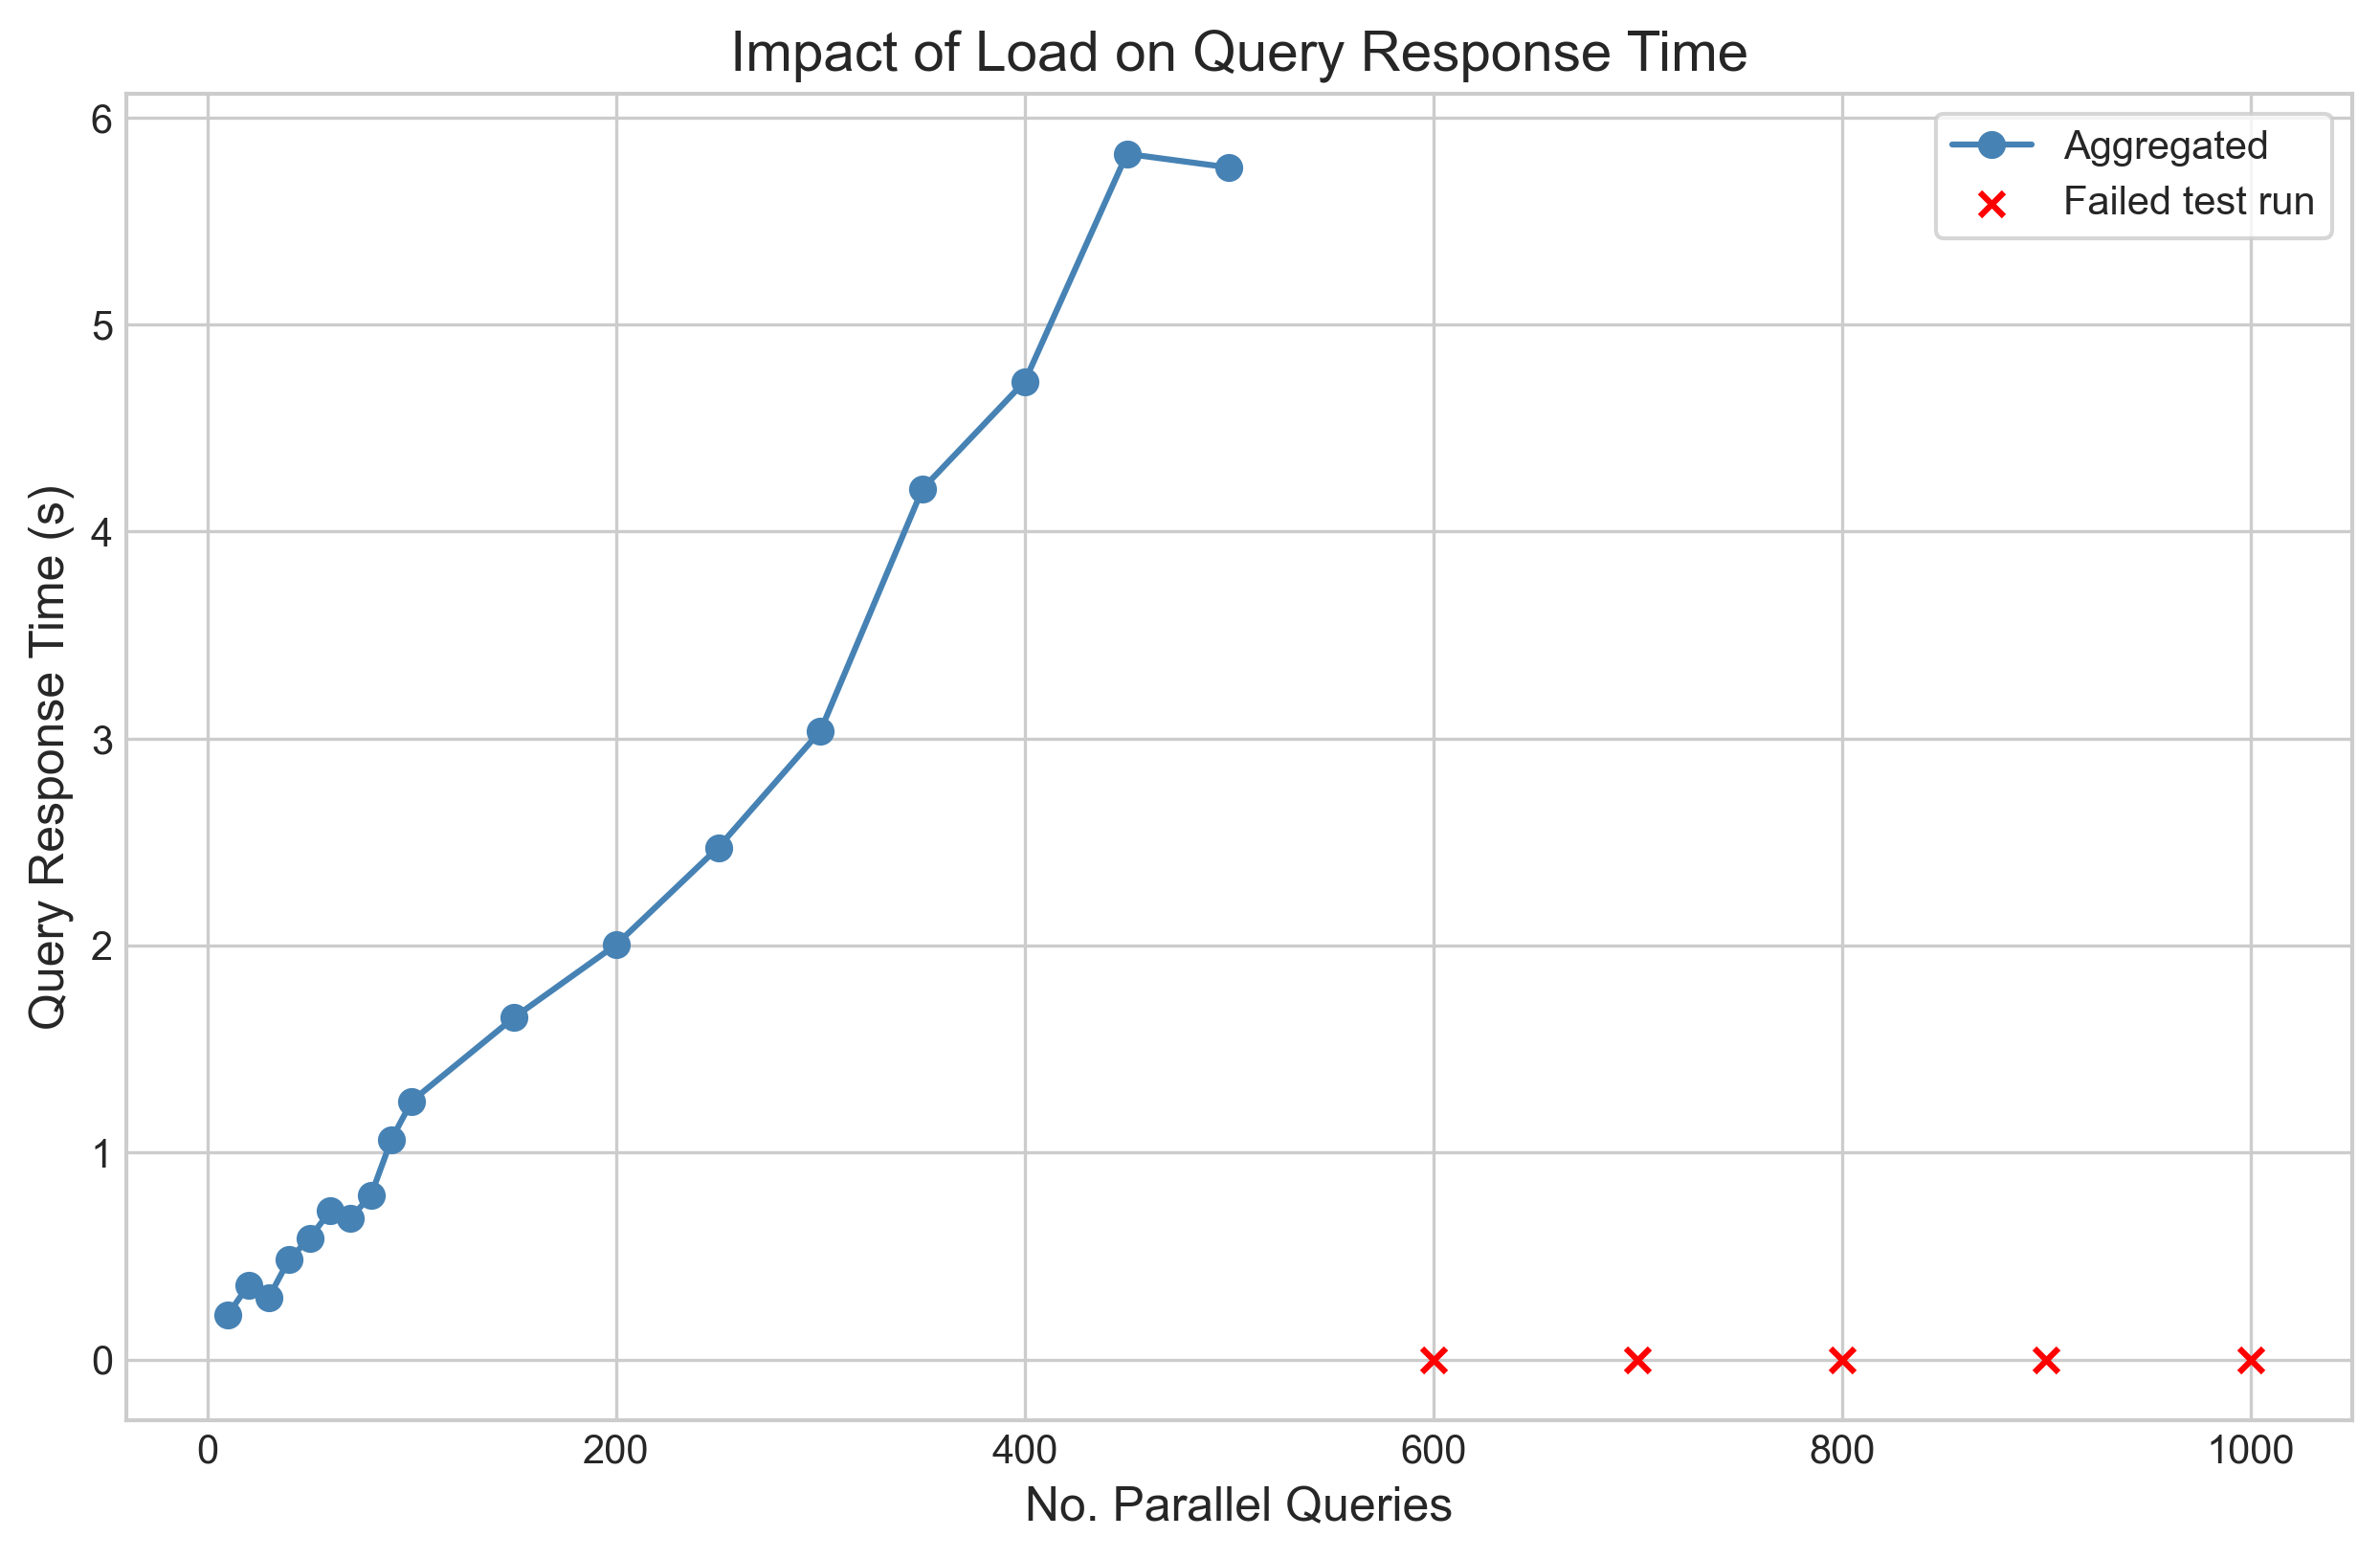

In [21]:
df_a = df_result_aggregated

x_column_name = 'parallel_queries'
y_column_name = 'avg_req_time'

title = 'Impact of Load on Query Response Time'
x_label = 'No. Parallel Queries'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a)

plt.show()

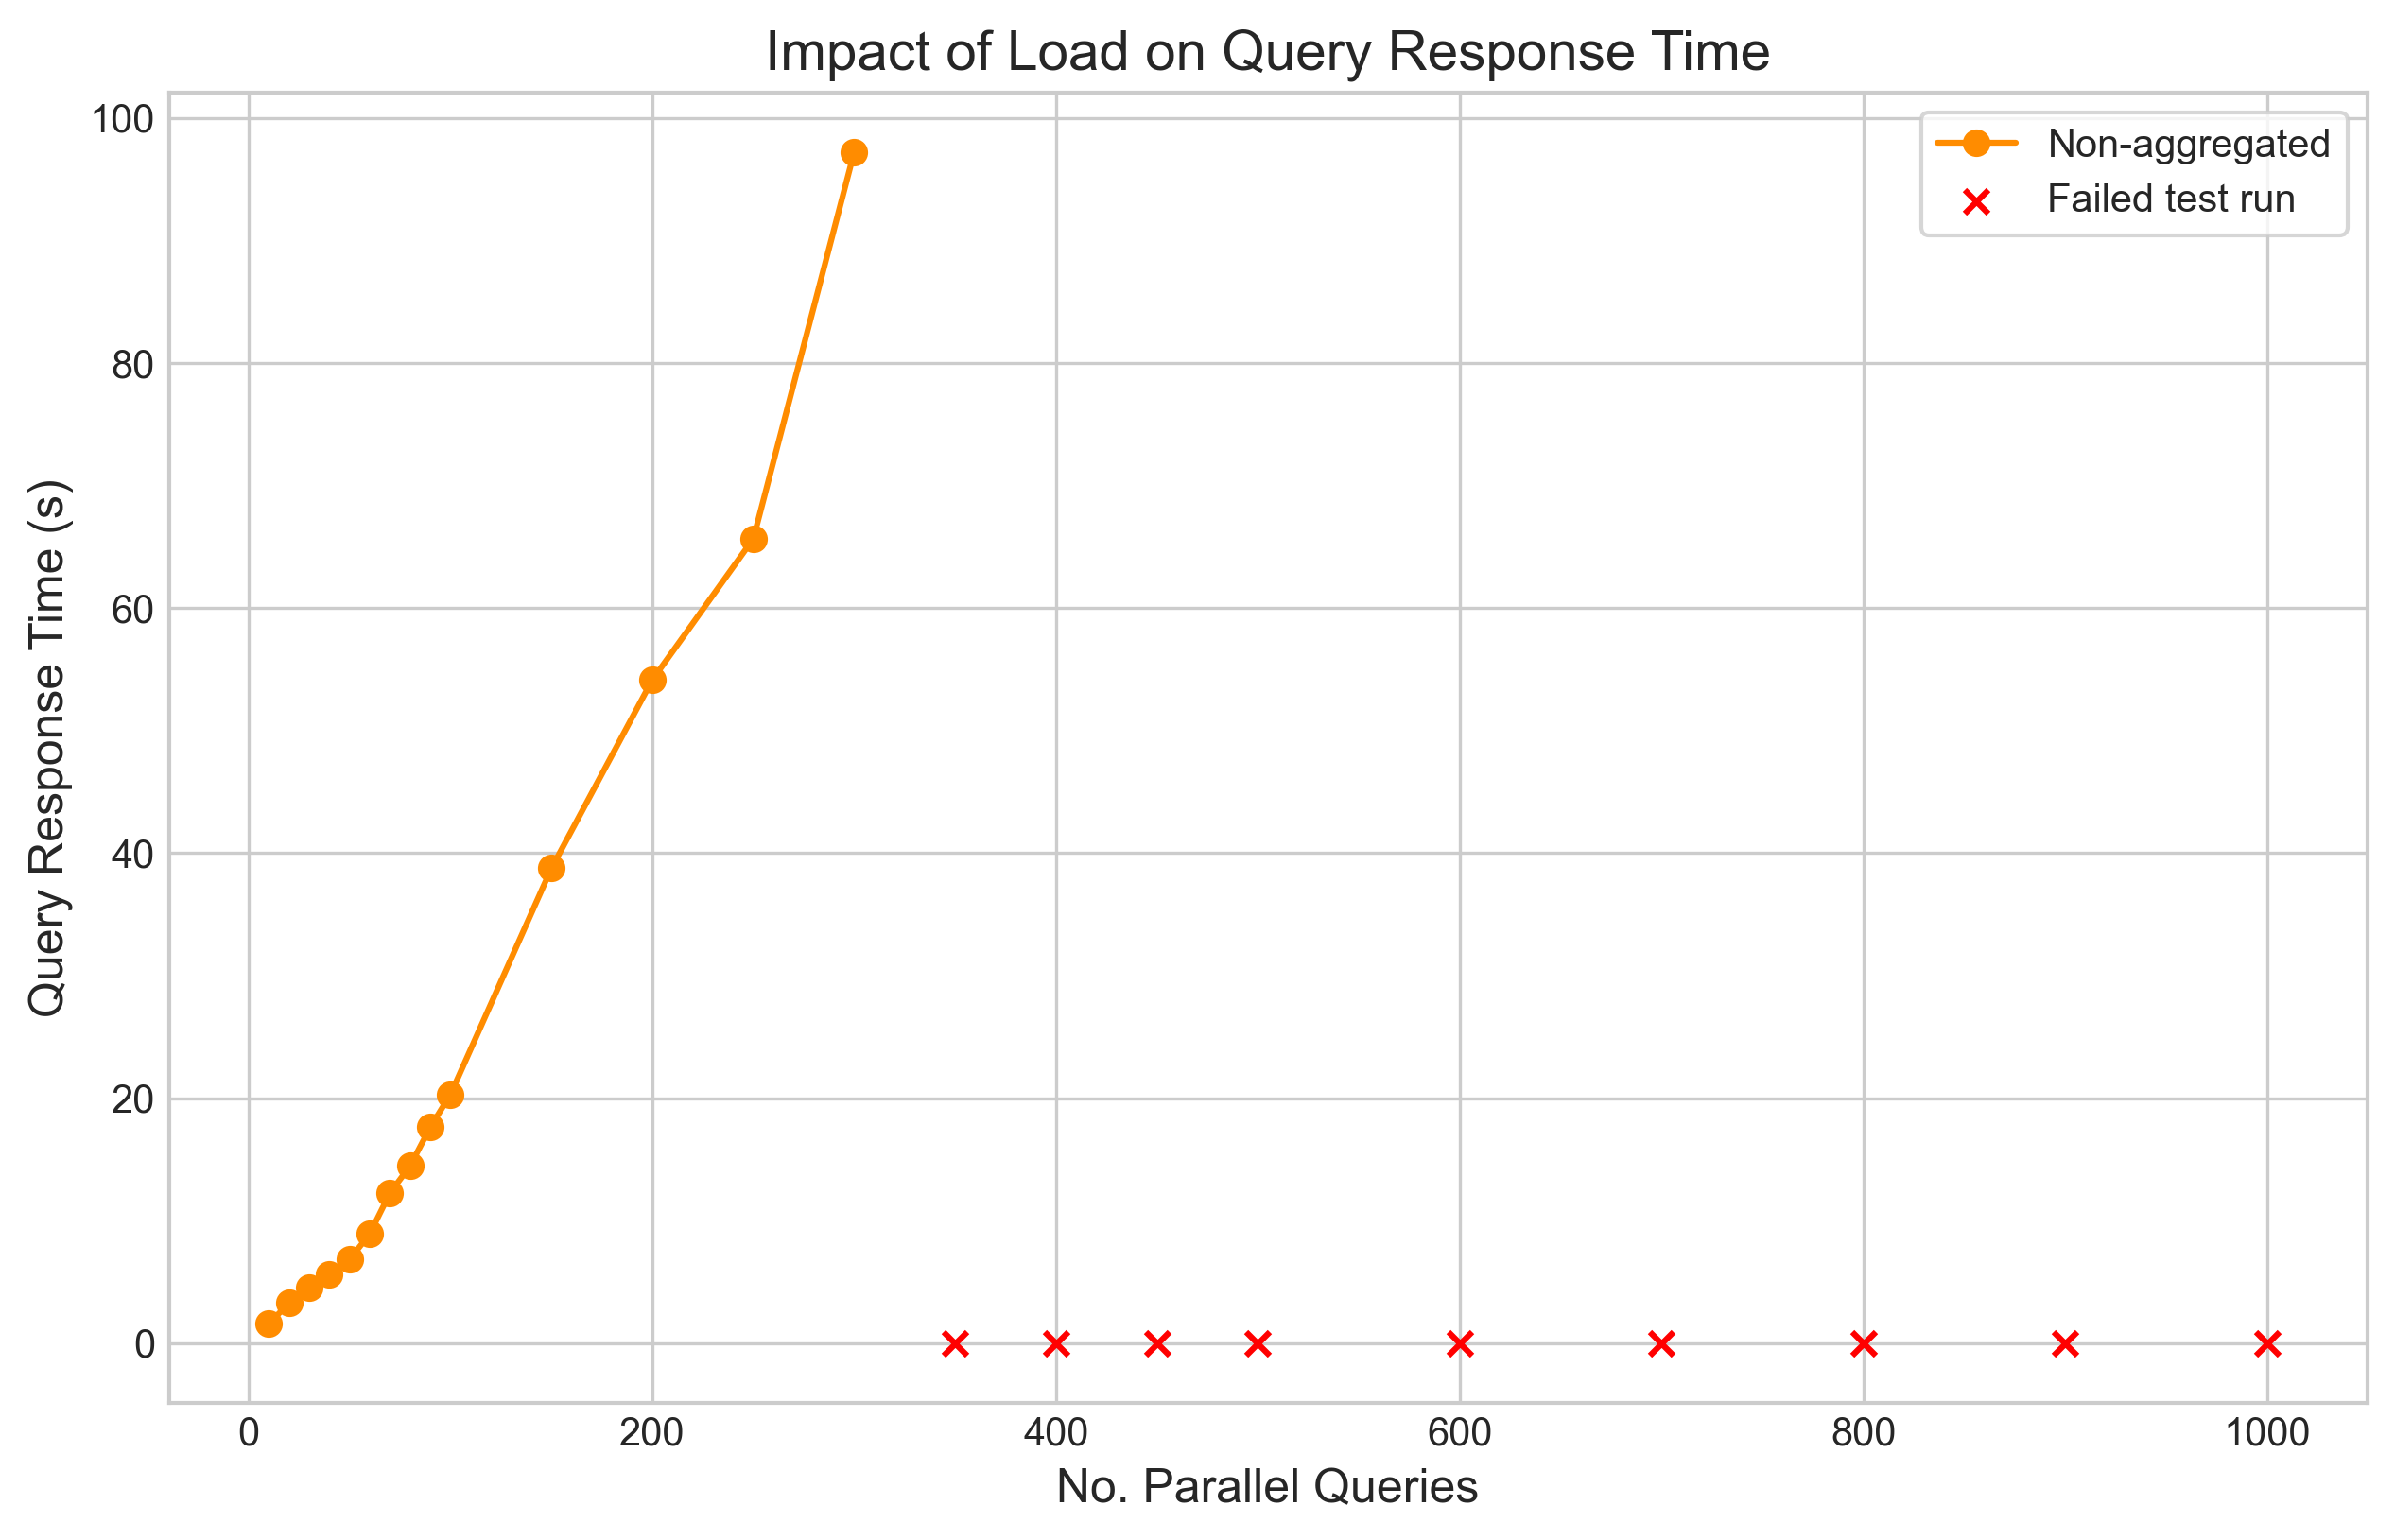

In [22]:
df_a = df_result_non_aggregated

x_column_name = 'parallel_queries'
y_column_name = 'avg_req_time'

title = 'Impact of Load on Query Response Time'
x_label = 'No. Parallel Queries'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, aggregated=False)

plt.show()

## Test Results of Resource Scalability Tests

In [23]:
# Result data of resource scalability tests (aggregated)
df_result_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_resources_aggregated.csv'), sep=';', index_col=0)
df_result_aggregated = prepare_result_data(df_result_aggregated)

# Result data of resource scalability tests (non-aggregated)
df_result_non_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_resources_non_aggregated.csv'), sep=';', index_col=0)
df_result_non_aggregated = prepare_result_data(df_result_non_aggregated)

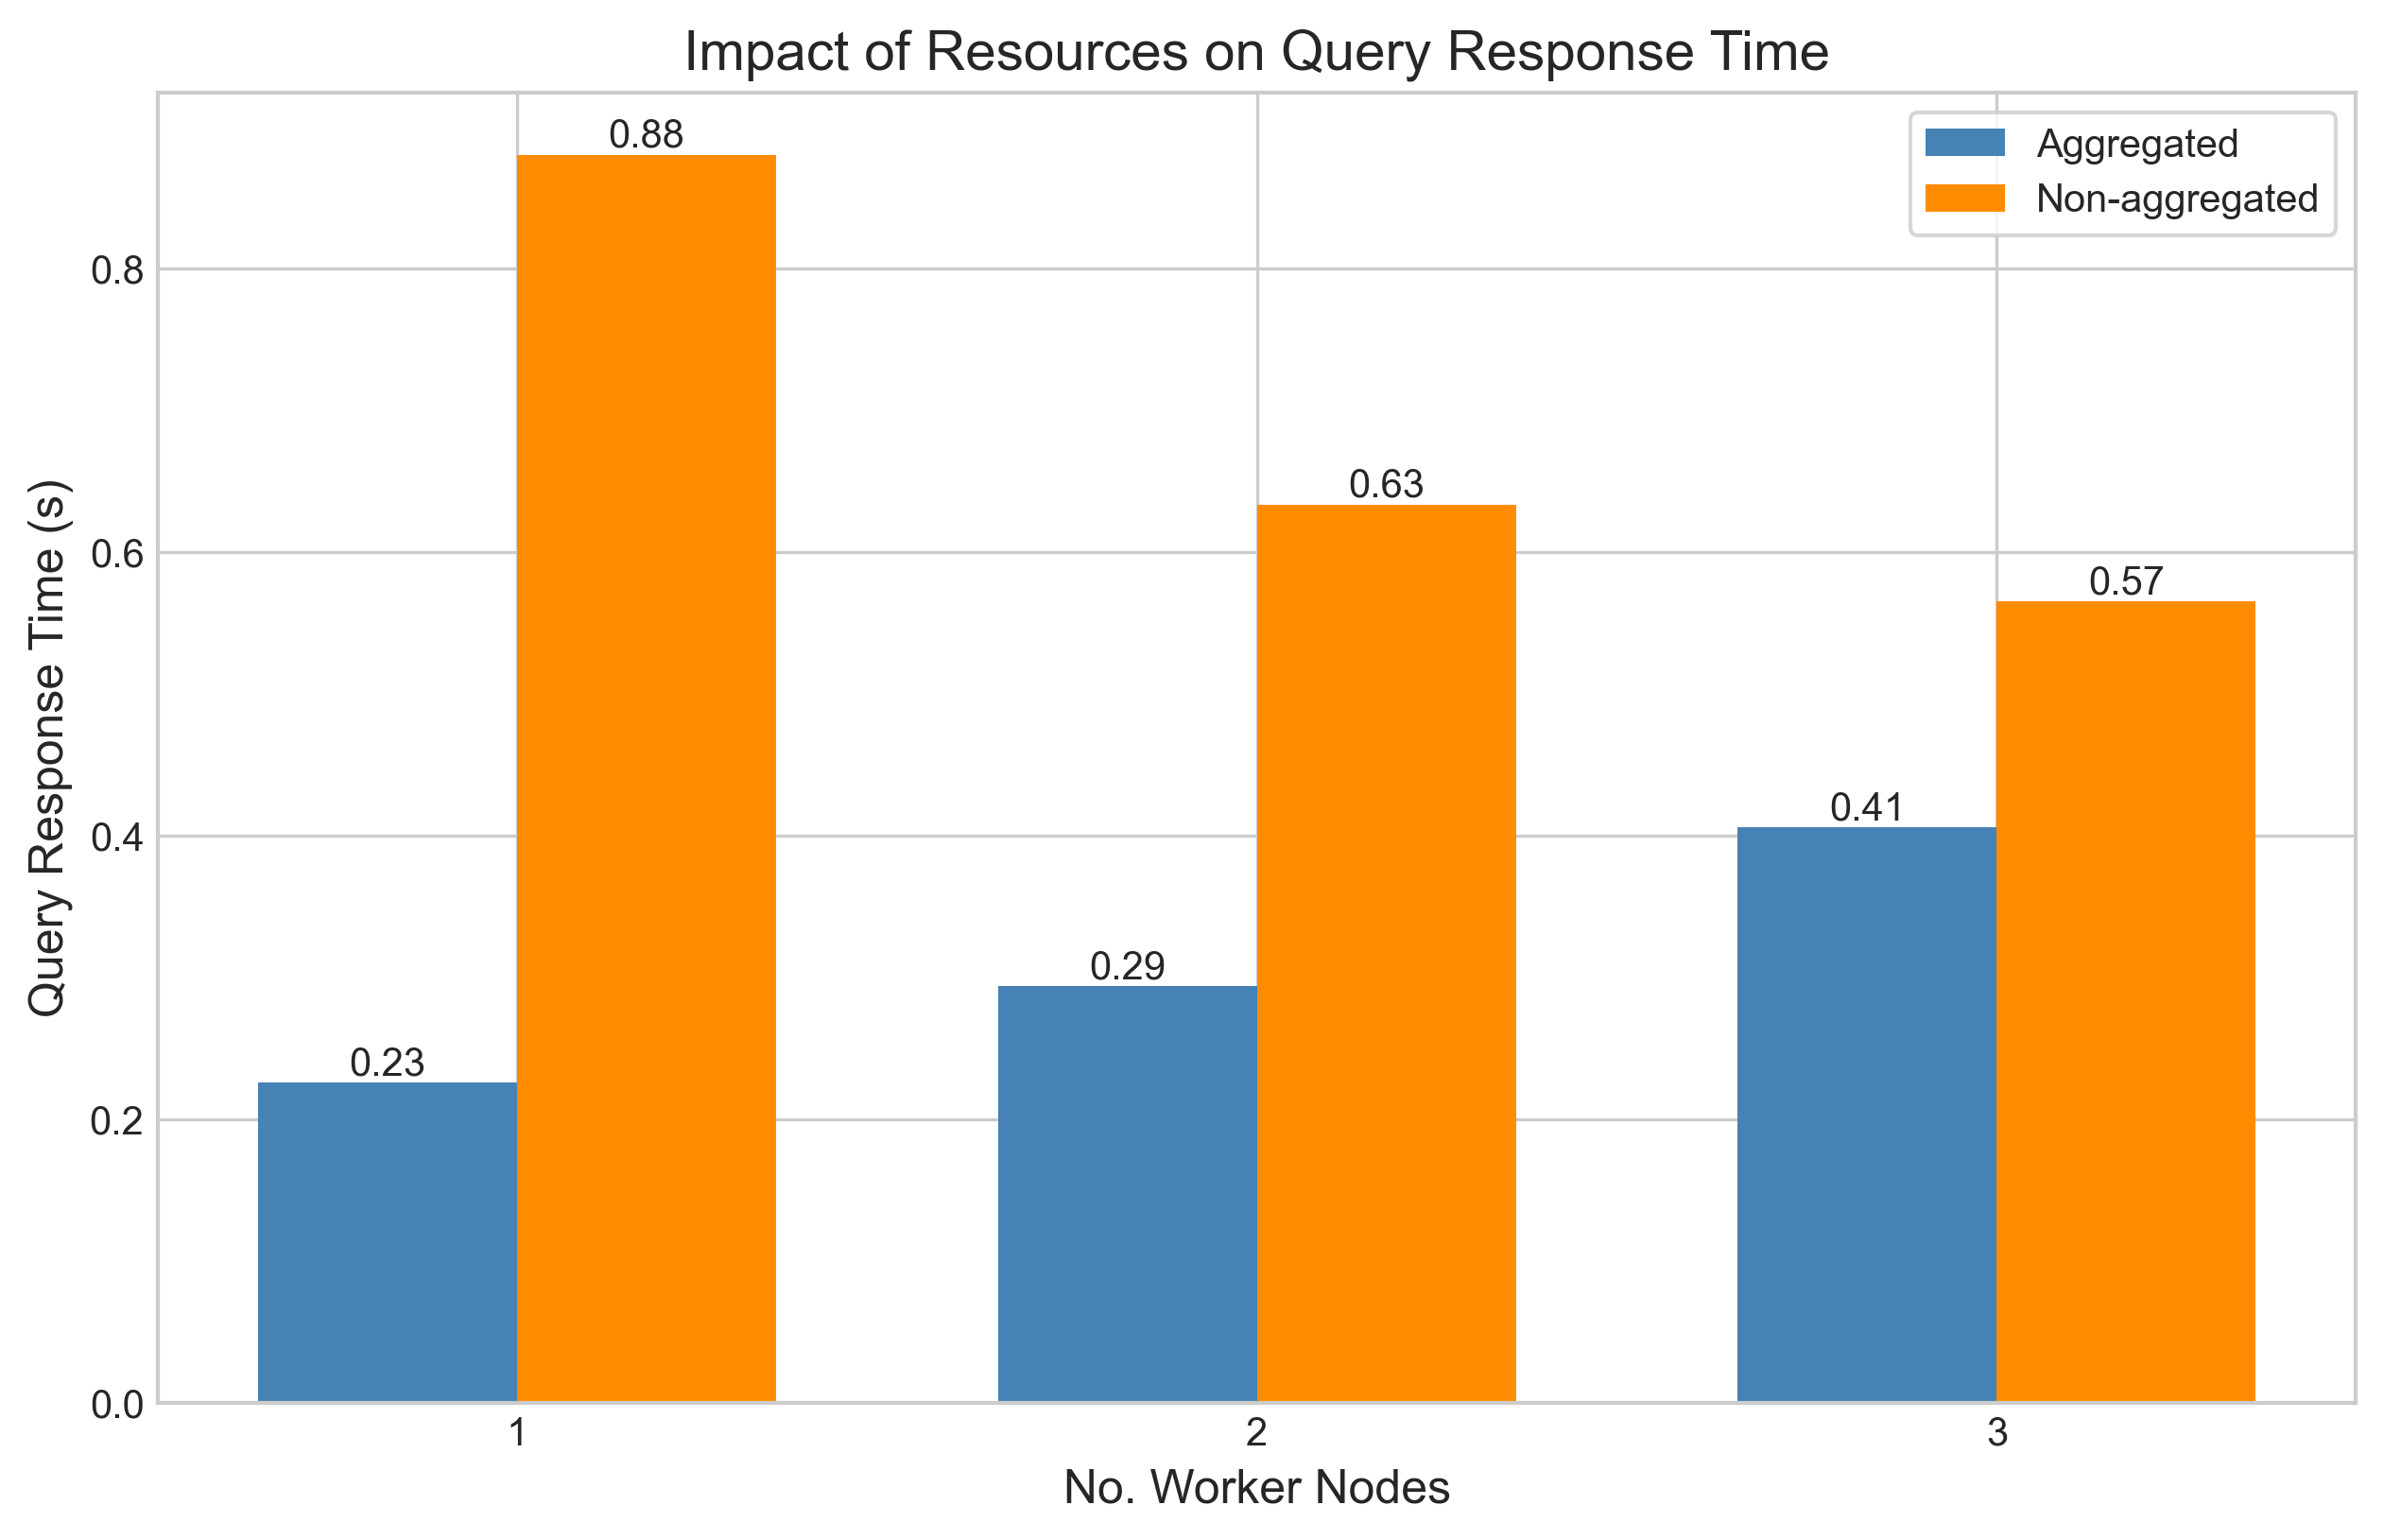

In [24]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'workers'
y_column_name = 'avg_req_time'

title = 'Impact of Resources on Query Response Time'
x_label = 'No. Worker Nodes'
y_label = 'Query Response Time (s)'

plot_bar_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()

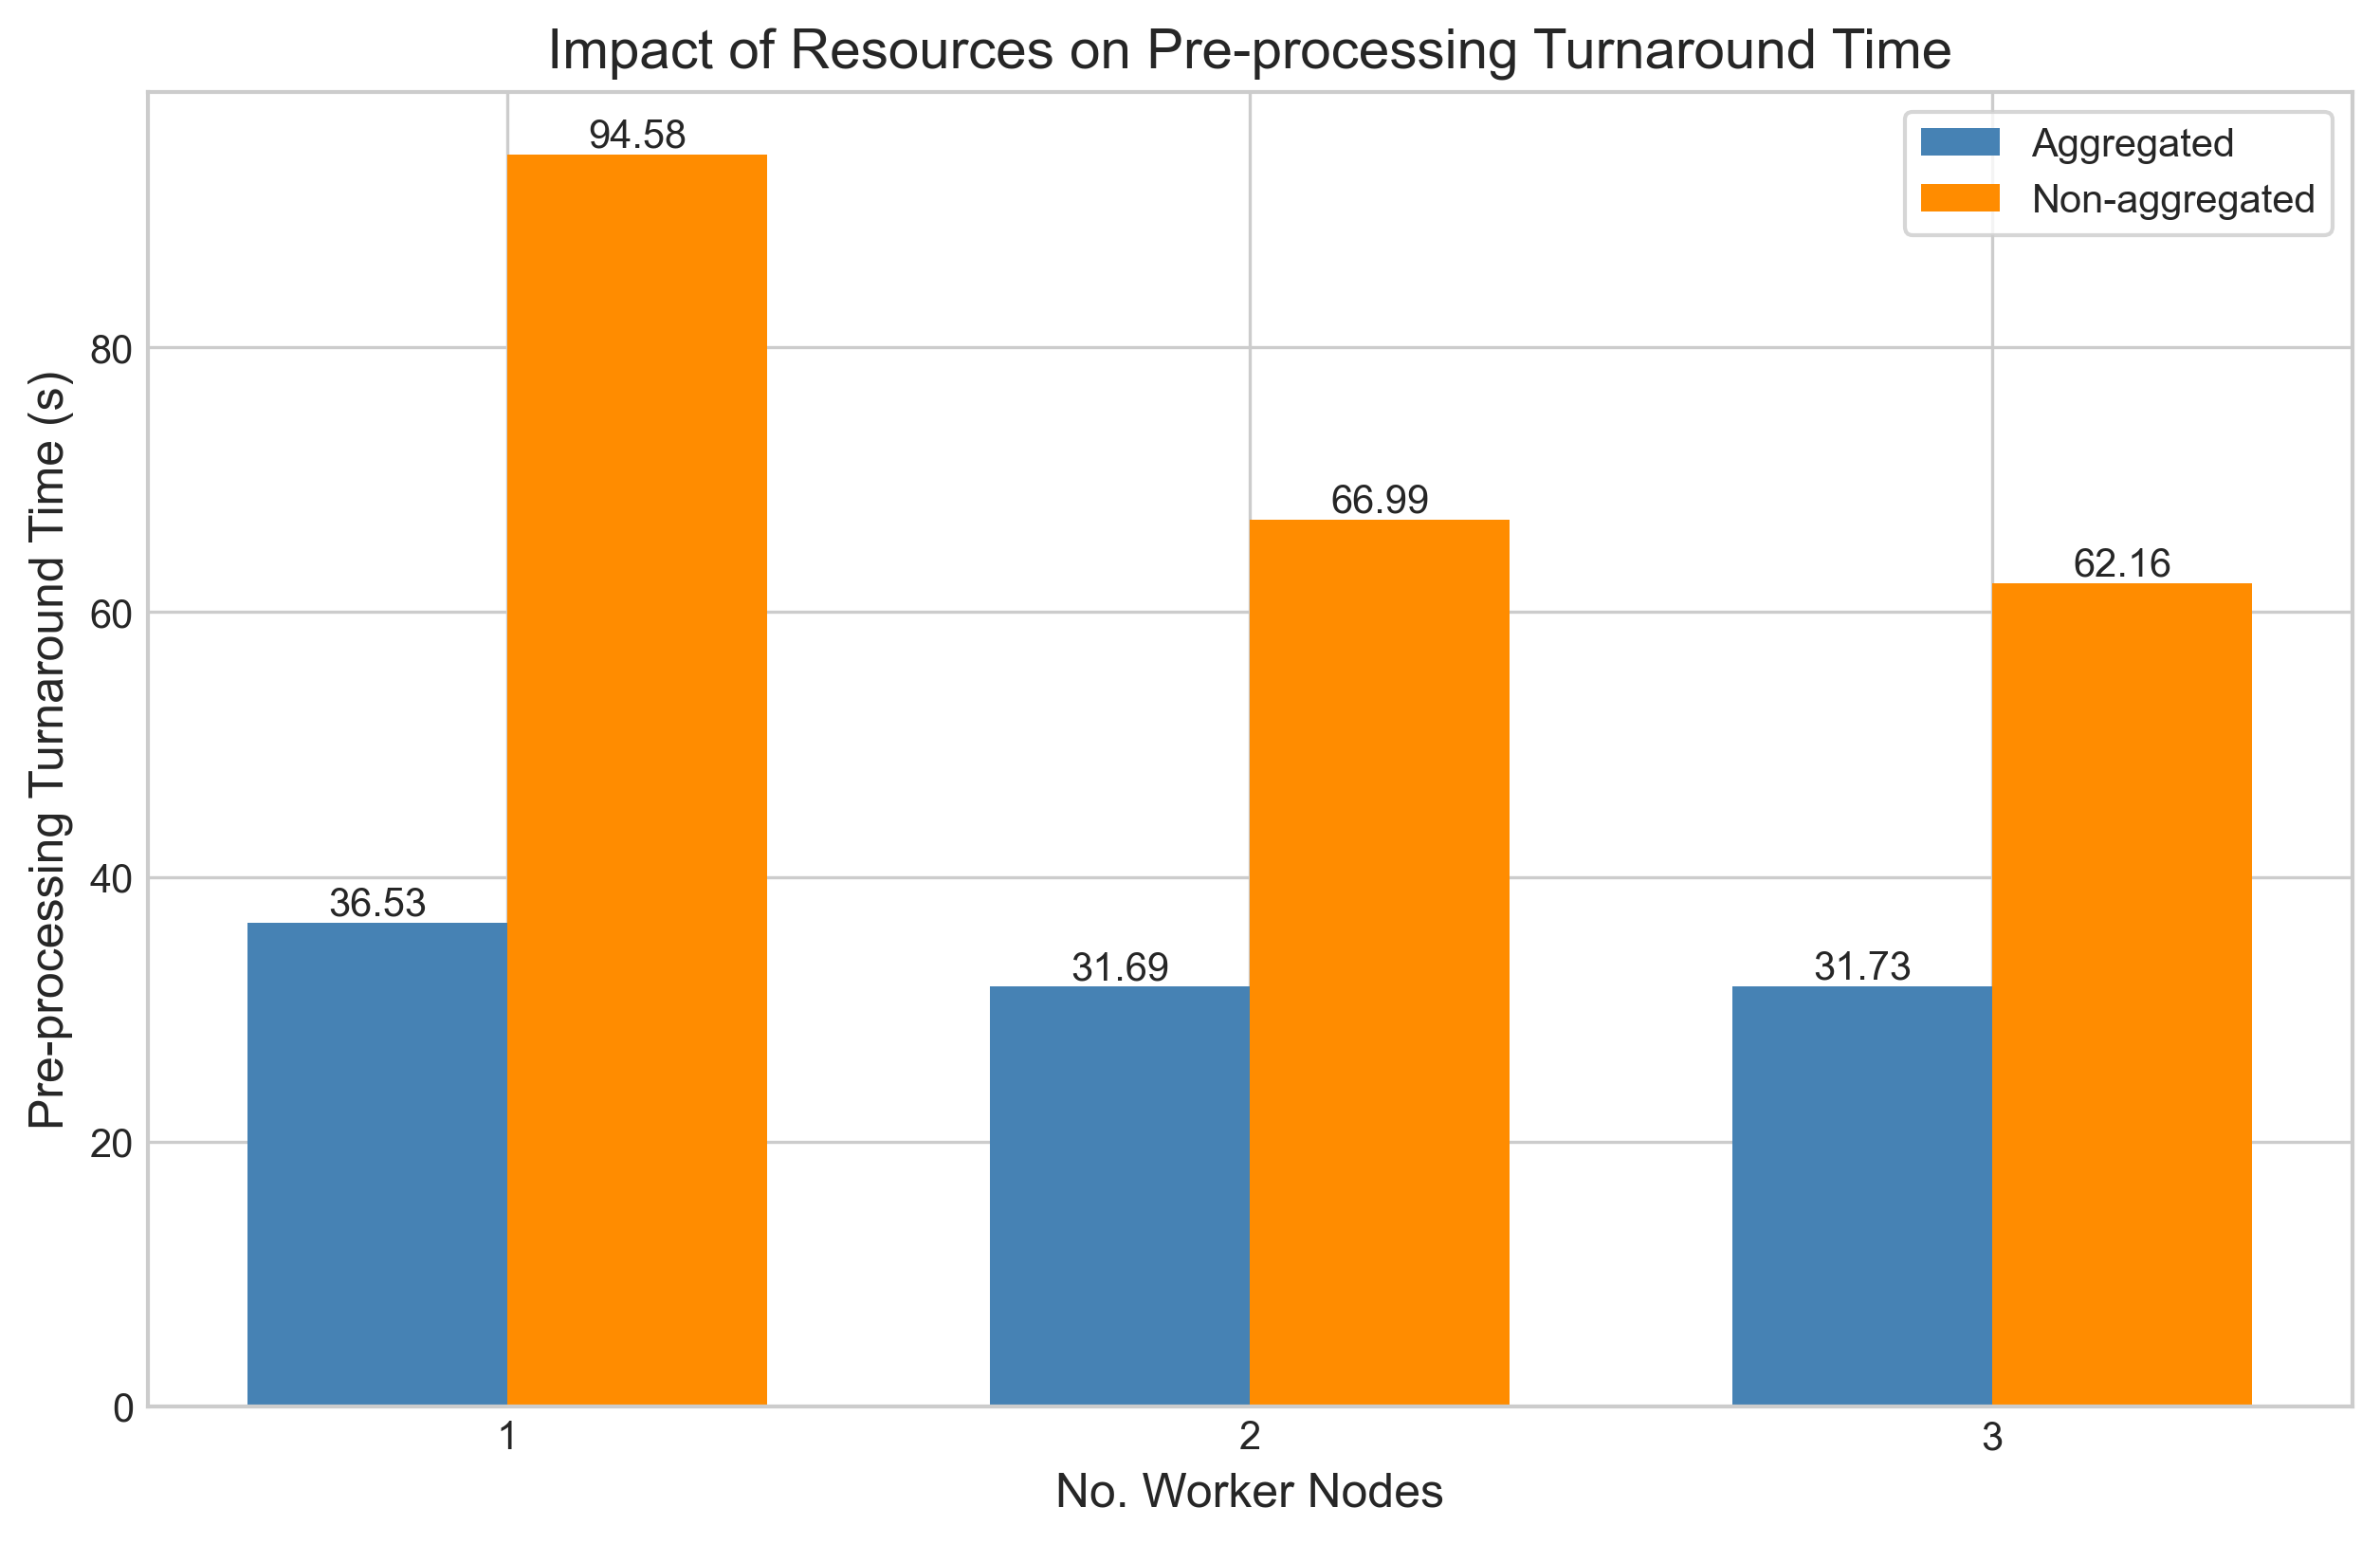

In [25]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'workers'
y_column_name = 'duration'

title = 'Impact of Resources on Pre-processing Turnaround Time'
x_label = 'No. Worker Nodes'
y_label = 'Pre-processing Turnaround Time (s)'

plot_bar_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()

## Test Results of Fault Tolerance Tests

In [26]:
# Result data of fault tolerance tests (aggregated)
df_result_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_fault_tolerance_aggregated.csv'), sep=';', index_col=0)
df_result_aggregated = prepare_result_data(df_result_aggregated)

# Result data of fault tolerance tests (non-aggregated)
df_result_non_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_fault_tolerance_non_aggregated.csv'), sep=';', index_col=0)
df_result_non_aggregated = prepare_result_data(df_result_non_aggregated)

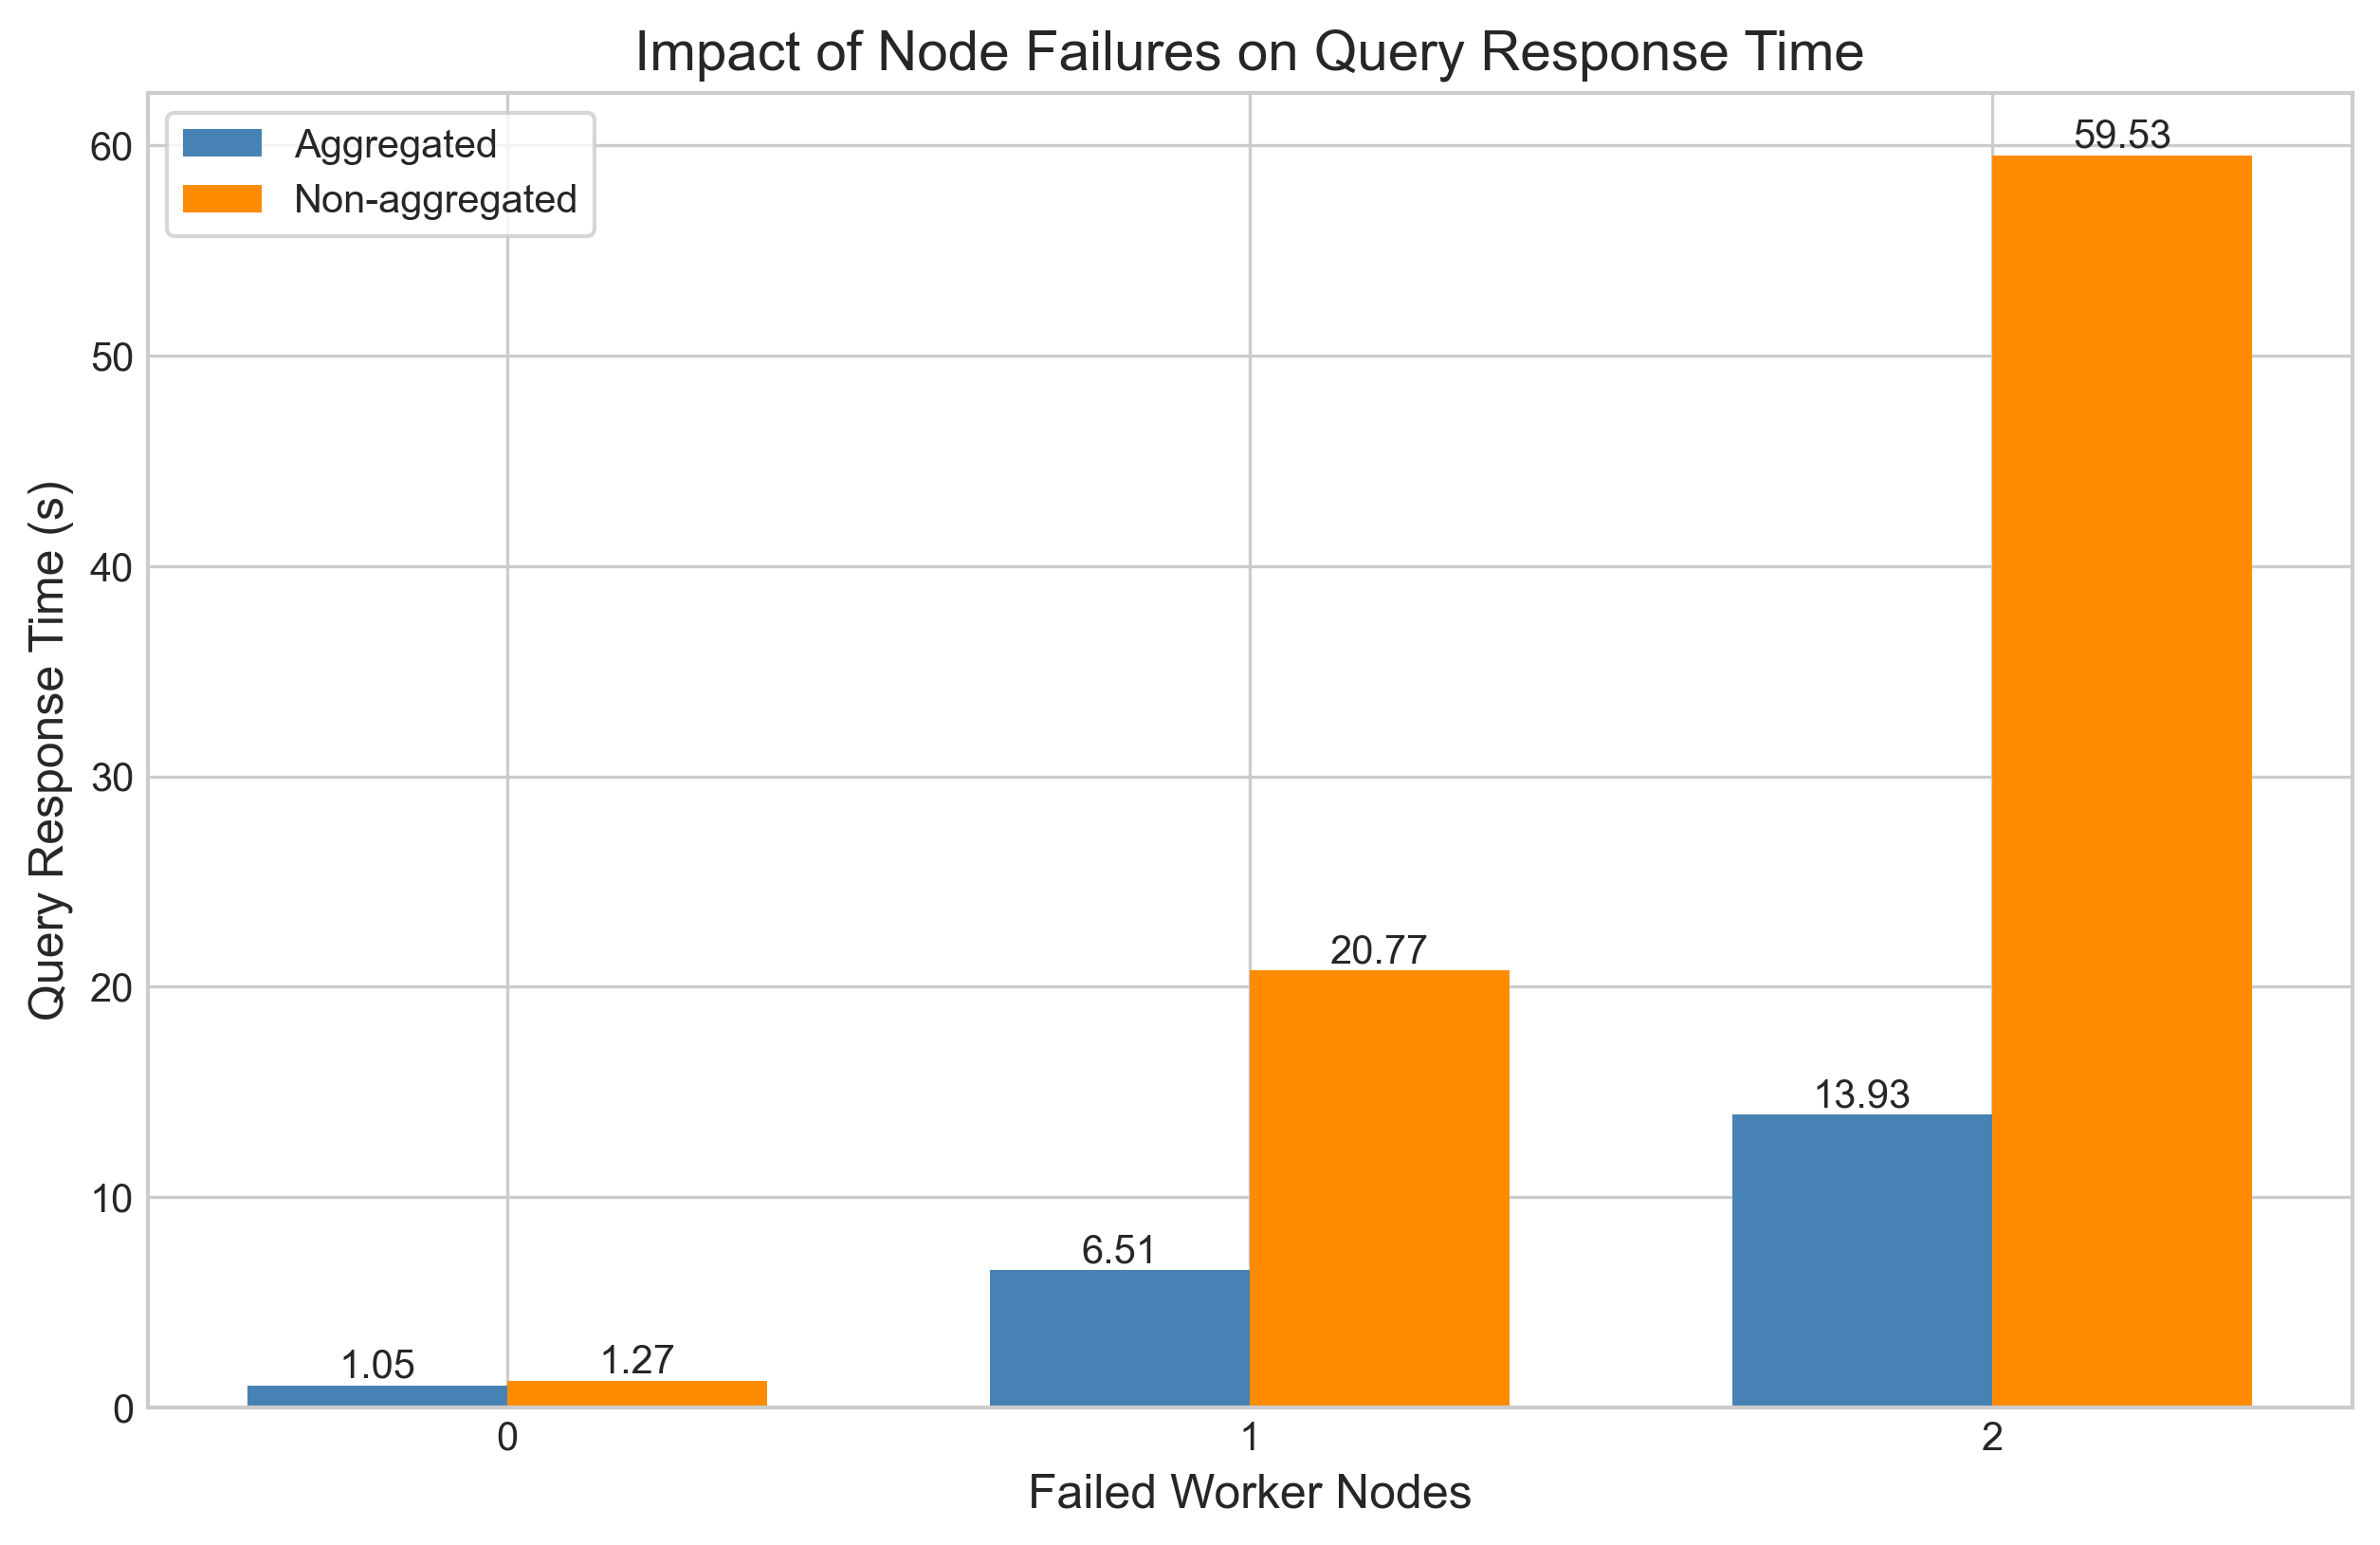

In [27]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'stopped_workers'
y_column_name = 'avg_req_time'

title = 'Impact of Node Failures on Query Response Time'
x_label = 'Failed Worker Nodes'
y_label = 'Query Response Time (s)'

plot_bar_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()